In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


In [2]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess = tf.Session()
graph = tf.get_default_graph()

# IMPORTANT: models have to be loaded AFTER SETTING THE SESSION for keras! 
# Otherwise, their weights will be unavailable in the threads after the session there has been set
set_session(sess)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            #if epoch>=19000:
            #    self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(r"C:\Users\rishi\Documents\CGAN Images\mnist_%d.png.png" % epoch)
        plt.close()

In [4]:
global sess
global graph
with graph.as_default():
    set_session(sess)
    dcgan = CGAN()
    dcgan.train(epochs=20000, batch_size=32, sample_interval=50)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_______________________________________

c:\users\rishi\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\users\rishi\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.701690, acc.: 3.12%] [G loss: 0.688804]
1 [D loss: 0.689113, acc.: 42.19%] [G loss: 0.682152]
2 [D loss: 0.684839, acc.: 48.44%] [G loss: 0.675121]
3 [D loss: 0.676966, acc.: 50.00%] [G loss: 0.667405]


c:\users\rishi\appdata\local\programs\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


4 [D loss: 0.670523, acc.: 50.00%] [G loss: 0.658322]
5 [D loss: 0.660083, acc.: 50.00%] [G loss: 0.647685]
6 [D loss: 0.645825, acc.: 50.00%] [G loss: 0.641295]
7 [D loss: 0.635171, acc.: 50.00%] [G loss: 0.633344]
8 [D loss: 0.617728, acc.: 50.00%] [G loss: 0.623361]
9 [D loss: 0.594931, acc.: 50.00%] [G loss: 0.611458]
10 [D loss: 0.566417, acc.: 51.56%] [G loss: 0.586400]
11 [D loss: 0.532615, acc.: 57.81%] [G loss: 0.577424]
12 [D loss: 0.483003, acc.: 87.50%] [G loss: 0.558348]
13 [D loss: 0.444426, acc.: 87.50%] [G loss: 0.561632]
14 [D loss: 0.414507, acc.: 95.31%] [G loss: 0.559122]
15 [D loss: 0.372588, acc.: 98.44%] [G loss: 0.557039]
16 [D loss: 0.342931, acc.: 96.88%] [G loss: 0.556385]
17 [D loss: 0.311628, acc.: 100.00%] [G loss: 0.559042]
18 [D loss: 0.283023, acc.: 100.00%] [G loss: 0.596612]
19 [D loss: 0.265154, acc.: 100.00%] [G loss: 0.626169]
20 [D loss: 0.231517, acc.: 100.00%] [G loss: 0.615813]
21 [D loss: 0.201334, acc.: 100.00%] [G loss: 0.639653]
22 [D loss:

153 [D loss: 0.201237, acc.: 89.06%] [G loss: 4.945327]
154 [D loss: 0.083293, acc.: 100.00%] [G loss: 6.465783]
155 [D loss: 0.121286, acc.: 96.88%] [G loss: 5.331027]
156 [D loss: 0.283806, acc.: 90.62%] [G loss: 5.805712]
157 [D loss: 0.211465, acc.: 90.62%] [G loss: 5.921947]
158 [D loss: 0.349599, acc.: 85.94%] [G loss: 5.974514]
159 [D loss: 0.204195, acc.: 92.19%] [G loss: 6.265713]
160 [D loss: 0.194906, acc.: 90.62%] [G loss: 5.699405]
161 [D loss: 0.155658, acc.: 92.19%] [G loss: 5.555513]
162 [D loss: 0.337112, acc.: 81.25%] [G loss: 6.852601]
163 [D loss: 0.224189, acc.: 89.06%] [G loss: 6.120351]
164 [D loss: 0.169230, acc.: 95.31%] [G loss: 5.690654]
165 [D loss: 0.149875, acc.: 95.31%] [G loss: 5.593307]
166 [D loss: 0.281669, acc.: 85.94%] [G loss: 5.587978]
167 [D loss: 0.134875, acc.: 95.31%] [G loss: 5.200330]
168 [D loss: 0.307336, acc.: 84.38%] [G loss: 6.573063]
169 [D loss: 0.335690, acc.: 84.38%] [G loss: 5.408217]
170 [D loss: 0.360529, acc.: 81.25%] [G loss: 6

301 [D loss: 0.450603, acc.: 78.12%] [G loss: 2.937718]
302 [D loss: 0.297112, acc.: 87.50%] [G loss: 2.944927]
303 [D loss: 0.311567, acc.: 84.38%] [G loss: 2.829529]
304 [D loss: 0.428871, acc.: 81.25%] [G loss: 2.723207]
305 [D loss: 0.294417, acc.: 84.38%] [G loss: 3.079916]
306 [D loss: 0.337508, acc.: 89.06%] [G loss: 2.802085]
307 [D loss: 0.347552, acc.: 84.38%] [G loss: 3.465021]
308 [D loss: 0.296867, acc.: 85.94%] [G loss: 2.786914]
309 [D loss: 0.283656, acc.: 89.06%] [G loss: 2.998477]
310 [D loss: 0.350547, acc.: 85.94%] [G loss: 2.792985]
311 [D loss: 0.221031, acc.: 93.75%] [G loss: 2.956496]
312 [D loss: 0.254823, acc.: 90.62%] [G loss: 2.884728]
313 [D loss: 0.311817, acc.: 84.38%] [G loss: 2.825611]
314 [D loss: 0.321086, acc.: 84.38%] [G loss: 3.106709]
315 [D loss: 0.427309, acc.: 79.69%] [G loss: 3.134731]
316 [D loss: 0.436417, acc.: 82.81%] [G loss: 2.479659]
317 [D loss: 0.280241, acc.: 89.06%] [G loss: 2.632823]
318 [D loss: 0.342098, acc.: 81.25%] [G loss: 3.

448 [D loss: 0.431863, acc.: 81.25%] [G loss: 1.992815]
449 [D loss: 0.523354, acc.: 68.75%] [G loss: 2.493775]
450 [D loss: 0.455522, acc.: 79.69%] [G loss: 2.115383]
451 [D loss: 0.552191, acc.: 70.31%] [G loss: 2.438443]
452 [D loss: 0.509134, acc.: 76.56%] [G loss: 2.254429]
453 [D loss: 0.421896, acc.: 79.69%] [G loss: 1.936345]
454 [D loss: 0.626507, acc.: 60.94%] [G loss: 2.371824]
455 [D loss: 0.447858, acc.: 81.25%] [G loss: 2.620184]
456 [D loss: 0.831977, acc.: 50.00%] [G loss: 2.235602]
457 [D loss: 0.508005, acc.: 73.44%] [G loss: 2.407527]
458 [D loss: 0.750884, acc.: 54.69%] [G loss: 2.367347]
459 [D loss: 0.427175, acc.: 78.12%] [G loss: 2.307881]
460 [D loss: 0.547908, acc.: 70.31%] [G loss: 1.679209]
461 [D loss: 0.469173, acc.: 76.56%] [G loss: 1.933772]
462 [D loss: 0.517724, acc.: 76.56%] [G loss: 2.007905]
463 [D loss: 0.423450, acc.: 78.12%] [G loss: 1.590090]
464 [D loss: 0.398068, acc.: 82.81%] [G loss: 2.186948]
465 [D loss: 0.574676, acc.: 71.88%] [G loss: 2.

595 [D loss: 0.579799, acc.: 64.06%] [G loss: 1.869274]
596 [D loss: 0.601968, acc.: 70.31%] [G loss: 1.913056]
597 [D loss: 0.729937, acc.: 68.75%] [G loss: 1.541208]
598 [D loss: 0.569100, acc.: 71.88%] [G loss: 1.549213]
599 [D loss: 0.534235, acc.: 76.56%] [G loss: 1.488001]
600 [D loss: 0.479950, acc.: 73.44%] [G loss: 2.084088]
601 [D loss: 0.555265, acc.: 76.56%] [G loss: 1.602626]
602 [D loss: 0.444205, acc.: 82.81%] [G loss: 1.675516]
603 [D loss: 0.447120, acc.: 81.25%] [G loss: 1.677090]
604 [D loss: 0.623356, acc.: 62.50%] [G loss: 1.685434]
605 [D loss: 0.537384, acc.: 70.31%] [G loss: 1.330754]
606 [D loss: 0.579950, acc.: 65.62%] [G loss: 1.412919]
607 [D loss: 0.531600, acc.: 76.56%] [G loss: 1.356578]
608 [D loss: 0.618467, acc.: 64.06%] [G loss: 1.642566]
609 [D loss: 0.586193, acc.: 67.19%] [G loss: 1.715983]
610 [D loss: 0.627615, acc.: 64.06%] [G loss: 1.868393]
611 [D loss: 0.534903, acc.: 76.56%] [G loss: 1.586152]
612 [D loss: 0.610101, acc.: 68.75%] [G loss: 1.

743 [D loss: 0.474667, acc.: 76.56%] [G loss: 1.839363]
744 [D loss: 0.360790, acc.: 82.81%] [G loss: 2.152256]
745 [D loss: 0.493513, acc.: 71.88%] [G loss: 1.801148]
746 [D loss: 0.430127, acc.: 78.12%] [G loss: 1.829984]
747 [D loss: 0.600922, acc.: 67.19%] [G loss: 1.851206]
748 [D loss: 0.485368, acc.: 76.56%] [G loss: 1.863412]
749 [D loss: 0.446489, acc.: 81.25%] [G loss: 1.681248]
750 [D loss: 0.505027, acc.: 79.69%] [G loss: 1.495979]
751 [D loss: 0.626721, acc.: 62.50%] [G loss: 1.908526]
752 [D loss: 0.302065, acc.: 93.75%] [G loss: 1.998764]
753 [D loss: 0.573254, acc.: 70.31%] [G loss: 1.721895]
754 [D loss: 0.486597, acc.: 76.56%] [G loss: 1.663041]
755 [D loss: 0.495684, acc.: 71.88%] [G loss: 1.745982]
756 [D loss: 0.424635, acc.: 79.69%] [G loss: 2.210037]
757 [D loss: 0.538410, acc.: 73.44%] [G loss: 1.719090]
758 [D loss: 0.393469, acc.: 81.25%] [G loss: 1.666806]
759 [D loss: 0.381610, acc.: 84.38%] [G loss: 1.975246]
760 [D loss: 0.517613, acc.: 81.25%] [G loss: 1.

892 [D loss: 0.641351, acc.: 64.06%] [G loss: 1.825735]
893 [D loss: 0.463021, acc.: 84.38%] [G loss: 1.587658]
894 [D loss: 0.685367, acc.: 59.38%] [G loss: 1.621500]
895 [D loss: 0.535656, acc.: 68.75%] [G loss: 1.907157]
896 [D loss: 0.510475, acc.: 78.12%] [G loss: 1.585540]
897 [D loss: 0.593186, acc.: 70.31%] [G loss: 1.635736]
898 [D loss: 0.500867, acc.: 75.00%] [G loss: 1.429151]
899 [D loss: 0.467039, acc.: 81.25%] [G loss: 1.537001]
900 [D loss: 0.569399, acc.: 71.88%] [G loss: 1.542020]
901 [D loss: 0.546640, acc.: 68.75%] [G loss: 1.771469]
902 [D loss: 0.590217, acc.: 68.75%] [G loss: 1.505193]
903 [D loss: 0.512874, acc.: 78.12%] [G loss: 1.496468]
904 [D loss: 0.511610, acc.: 71.88%] [G loss: 1.643515]
905 [D loss: 0.545555, acc.: 67.19%] [G loss: 1.488219]
906 [D loss: 0.577785, acc.: 65.62%] [G loss: 1.608814]
907 [D loss: 0.629499, acc.: 64.06%] [G loss: 1.599848]
908 [D loss: 0.561601, acc.: 65.62%] [G loss: 1.360714]
909 [D loss: 0.494756, acc.: 75.00%] [G loss: 1.

1038 [D loss: 0.646864, acc.: 67.19%] [G loss: 1.445485]
1039 [D loss: 0.555175, acc.: 71.88%] [G loss: 1.838570]
1040 [D loss: 0.622021, acc.: 64.06%] [G loss: 1.455951]
1041 [D loss: 0.644879, acc.: 64.06%] [G loss: 1.563473]
1042 [D loss: 0.627729, acc.: 62.50%] [G loss: 1.369306]
1043 [D loss: 0.819373, acc.: 48.44%] [G loss: 1.264307]
1044 [D loss: 0.616360, acc.: 65.62%] [G loss: 1.360433]
1045 [D loss: 0.574543, acc.: 68.75%] [G loss: 1.250436]
1046 [D loss: 0.506894, acc.: 71.88%] [G loss: 1.388032]
1047 [D loss: 0.617282, acc.: 64.06%] [G loss: 1.317851]
1048 [D loss: 0.449081, acc.: 84.38%] [G loss: 1.659330]
1049 [D loss: 0.701013, acc.: 59.38%] [G loss: 1.364699]
1050 [D loss: 0.544050, acc.: 79.69%] [G loss: 1.683349]
1051 [D loss: 0.557891, acc.: 76.56%] [G loss: 1.233882]
1052 [D loss: 0.530805, acc.: 73.44%] [G loss: 1.430007]
1053 [D loss: 0.516637, acc.: 75.00%] [G loss: 1.335905]
1054 [D loss: 0.624770, acc.: 65.62%] [G loss: 1.434072]
1055 [D loss: 0.530147, acc.: 7

1325 [D loss: 0.639331, acc.: 59.38%] [G loss: 1.285752]
1326 [D loss: 0.531302, acc.: 73.44%] [G loss: 1.076421]
1327 [D loss: 0.642336, acc.: 64.06%] [G loss: 1.090230]
1328 [D loss: 0.563845, acc.: 73.44%] [G loss: 1.091749]
1329 [D loss: 0.615761, acc.: 67.19%] [G loss: 1.089784]
1330 [D loss: 0.645791, acc.: 57.81%] [G loss: 1.231085]
1331 [D loss: 0.654704, acc.: 60.94%] [G loss: 1.201413]
1332 [D loss: 0.622361, acc.: 68.75%] [G loss: 1.074921]
1333 [D loss: 0.522806, acc.: 70.31%] [G loss: 1.179005]
1334 [D loss: 0.608538, acc.: 70.31%] [G loss: 1.022337]
1335 [D loss: 0.621013, acc.: 65.62%] [G loss: 0.995799]
1336 [D loss: 0.542954, acc.: 73.44%] [G loss: 1.202001]
1337 [D loss: 0.610707, acc.: 64.06%] [G loss: 1.239145]
1338 [D loss: 0.630983, acc.: 62.50%] [G loss: 1.145083]
1339 [D loss: 0.644744, acc.: 65.62%] [G loss: 1.135146]
1340 [D loss: 0.630119, acc.: 64.06%] [G loss: 1.170426]
1341 [D loss: 0.573098, acc.: 68.75%] [G loss: 1.120534]
1342 [D loss: 0.563163, acc.: 6

1469 [D loss: 0.593653, acc.: 65.62%] [G loss: 1.186172]
1470 [D loss: 0.695908, acc.: 54.69%] [G loss: 1.115651]
1471 [D loss: 0.578827, acc.: 65.62%] [G loss: 1.155758]
1472 [D loss: 0.627548, acc.: 60.94%] [G loss: 1.256757]
1473 [D loss: 0.543432, acc.: 76.56%] [G loss: 1.122182]
1474 [D loss: 0.563178, acc.: 71.88%] [G loss: 1.096475]
1475 [D loss: 0.685946, acc.: 59.38%] [G loss: 1.224454]
1476 [D loss: 0.525036, acc.: 73.44%] [G loss: 1.331237]
1477 [D loss: 0.659771, acc.: 57.81%] [G loss: 1.115206]
1478 [D loss: 0.583211, acc.: 67.19%] [G loss: 1.081753]
1479 [D loss: 0.586120, acc.: 60.94%] [G loss: 1.176822]
1480 [D loss: 0.602872, acc.: 67.19%] [G loss: 1.103442]
1481 [D loss: 0.505026, acc.: 81.25%] [G loss: 1.056482]
1482 [D loss: 0.596984, acc.: 64.06%] [G loss: 1.114811]
1483 [D loss: 0.626919, acc.: 68.75%] [G loss: 1.255063]
1484 [D loss: 0.649216, acc.: 60.94%] [G loss: 1.281606]
1485 [D loss: 0.705673, acc.: 48.44%] [G loss: 1.309658]
1486 [D loss: 0.585053, acc.: 6

1614 [D loss: 0.666799, acc.: 57.81%] [G loss: 1.018910]
1615 [D loss: 0.574980, acc.: 70.31%] [G loss: 1.181574]
1616 [D loss: 0.562403, acc.: 68.75%] [G loss: 1.181004]
1617 [D loss: 0.528997, acc.: 76.56%] [G loss: 1.149030]
1618 [D loss: 0.574596, acc.: 68.75%] [G loss: 1.017668]
1619 [D loss: 0.621344, acc.: 68.75%] [G loss: 1.099012]
1620 [D loss: 0.552816, acc.: 73.44%] [G loss: 1.298715]
1621 [D loss: 0.687997, acc.: 60.94%] [G loss: 1.068017]
1622 [D loss: 0.564070, acc.: 73.44%] [G loss: 1.206775]
1623 [D loss: 0.630744, acc.: 60.94%] [G loss: 0.927452]
1624 [D loss: 0.670847, acc.: 59.38%] [G loss: 1.062617]
1625 [D loss: 0.618876, acc.: 68.75%] [G loss: 1.122267]
1626 [D loss: 0.598311, acc.: 62.50%] [G loss: 1.064413]
1627 [D loss: 0.651609, acc.: 54.69%] [G loss: 1.118538]
1628 [D loss: 0.549750, acc.: 71.88%] [G loss: 1.088440]
1629 [D loss: 0.755173, acc.: 57.81%] [G loss: 0.971192]
1630 [D loss: 0.658756, acc.: 64.06%] [G loss: 1.146339]
1631 [D loss: 0.654070, acc.: 5

1760 [D loss: 0.666345, acc.: 64.06%] [G loss: 0.930926]
1761 [D loss: 0.637508, acc.: 70.31%] [G loss: 0.942416]
1762 [D loss: 0.701142, acc.: 56.25%] [G loss: 0.882878]
1763 [D loss: 0.674104, acc.: 56.25%] [G loss: 0.910691]
1764 [D loss: 0.679642, acc.: 57.81%] [G loss: 0.927828]
1765 [D loss: 0.639493, acc.: 64.06%] [G loss: 0.947774]
1766 [D loss: 0.661653, acc.: 62.50%] [G loss: 0.942290]
1767 [D loss: 0.655828, acc.: 54.69%] [G loss: 0.924266]
1768 [D loss: 0.643736, acc.: 68.75%] [G loss: 0.923125]
1769 [D loss: 0.584540, acc.: 70.31%] [G loss: 0.922320]
1770 [D loss: 0.669849, acc.: 59.38%] [G loss: 1.005050]
1771 [D loss: 0.682655, acc.: 57.81%] [G loss: 0.864204]
1772 [D loss: 0.724724, acc.: 54.69%] [G loss: 0.863321]
1773 [D loss: 0.645262, acc.: 60.94%] [G loss: 0.937498]
1774 [D loss: 0.757528, acc.: 51.56%] [G loss: 0.966034]
1775 [D loss: 0.573230, acc.: 68.75%] [G loss: 0.936044]
1776 [D loss: 0.693411, acc.: 53.12%] [G loss: 0.917169]
1777 [D loss: 0.704673, acc.: 5

1904 [D loss: 0.644522, acc.: 59.38%] [G loss: 0.997219]
1905 [D loss: 0.643714, acc.: 64.06%] [G loss: 1.005512]
1906 [D loss: 0.732849, acc.: 54.69%] [G loss: 1.014441]
1907 [D loss: 0.621741, acc.: 68.75%] [G loss: 0.907122]
1908 [D loss: 0.663963, acc.: 59.38%] [G loss: 0.938518]
1909 [D loss: 0.666750, acc.: 60.94%] [G loss: 0.920730]
1910 [D loss: 0.698273, acc.: 56.25%] [G loss: 0.887774]
1911 [D loss: 0.640324, acc.: 64.06%] [G loss: 0.953698]
1912 [D loss: 0.656494, acc.: 65.62%] [G loss: 0.964036]
1913 [D loss: 0.666453, acc.: 60.94%] [G loss: 0.958731]
1914 [D loss: 0.631080, acc.: 67.19%] [G loss: 0.883831]
1915 [D loss: 0.612226, acc.: 68.75%] [G loss: 0.930169]
1916 [D loss: 0.706728, acc.: 54.69%] [G loss: 0.878945]
1917 [D loss: 0.653821, acc.: 60.94%] [G loss: 1.010584]
1918 [D loss: 0.671431, acc.: 62.50%] [G loss: 0.957711]
1919 [D loss: 0.571950, acc.: 68.75%] [G loss: 1.020029]
1920 [D loss: 0.593165, acc.: 60.94%] [G loss: 0.909089]
1921 [D loss: 0.738953, acc.: 4

2192 [D loss: 0.660203, acc.: 48.44%] [G loss: 0.942352]
2193 [D loss: 0.678552, acc.: 60.94%] [G loss: 0.872523]
2194 [D loss: 0.653954, acc.: 51.56%] [G loss: 0.897655]
2195 [D loss: 0.626676, acc.: 60.94%] [G loss: 0.904948]
2196 [D loss: 0.626160, acc.: 70.31%] [G loss: 0.973363]
2197 [D loss: 0.656461, acc.: 67.19%] [G loss: 0.878312]
2198 [D loss: 0.629859, acc.: 64.06%] [G loss: 0.930167]
2199 [D loss: 0.700946, acc.: 48.44%] [G loss: 0.864236]
2200 [D loss: 0.702935, acc.: 51.56%] [G loss: 0.887473]
2201 [D loss: 0.665920, acc.: 46.88%] [G loss: 0.910019]
2202 [D loss: 0.649719, acc.: 65.62%] [G loss: 0.887805]
2203 [D loss: 0.684235, acc.: 54.69%] [G loss: 0.836344]
2204 [D loss: 0.664872, acc.: 57.81%] [G loss: 0.857032]
2205 [D loss: 0.648389, acc.: 57.81%] [G loss: 0.867440]
2206 [D loss: 0.649899, acc.: 70.31%] [G loss: 0.962886]
2207 [D loss: 0.673224, acc.: 56.25%] [G loss: 0.918507]
2208 [D loss: 0.651932, acc.: 64.06%] [G loss: 0.982455]
2209 [D loss: 0.696362, acc.: 6

2480 [D loss: 0.627950, acc.: 68.75%] [G loss: 0.905477]
2481 [D loss: 0.753317, acc.: 46.88%] [G loss: 0.969259]
2482 [D loss: 0.644135, acc.: 64.06%] [G loss: 0.932347]
2483 [D loss: 0.679368, acc.: 57.81%] [G loss: 0.894624]
2484 [D loss: 0.642161, acc.: 57.81%] [G loss: 1.011808]
2485 [D loss: 0.679480, acc.: 54.69%] [G loss: 0.913730]
2486 [D loss: 0.665415, acc.: 54.69%] [G loss: 0.916889]
2487 [D loss: 0.706362, acc.: 53.12%] [G loss: 0.895470]
2488 [D loss: 0.690272, acc.: 53.12%] [G loss: 0.879506]
2489 [D loss: 0.665660, acc.: 54.69%] [G loss: 0.934267]
2490 [D loss: 0.634074, acc.: 60.94%] [G loss: 0.935347]
2491 [D loss: 0.642681, acc.: 57.81%] [G loss: 0.905568]
2492 [D loss: 0.671142, acc.: 59.38%] [G loss: 0.933859]
2493 [D loss: 0.680606, acc.: 53.12%] [G loss: 0.896168]
2494 [D loss: 0.668139, acc.: 53.12%] [G loss: 0.871780]
2495 [D loss: 0.623442, acc.: 67.19%] [G loss: 0.872500]
2496 [D loss: 0.710543, acc.: 59.38%] [G loss: 0.873352]
2497 [D loss: 0.696649, acc.: 5

2625 [D loss: 0.634382, acc.: 60.94%] [G loss: 0.859128]
2626 [D loss: 0.687168, acc.: 51.56%] [G loss: 0.788925]
2627 [D loss: 0.697056, acc.: 53.12%] [G loss: 0.847789]
2628 [D loss: 0.720698, acc.: 54.69%] [G loss: 0.825037]
2629 [D loss: 0.681514, acc.: 56.25%] [G loss: 0.843371]
2630 [D loss: 0.642860, acc.: 60.94%] [G loss: 0.810583]
2631 [D loss: 0.687667, acc.: 53.12%] [G loss: 0.813406]
2632 [D loss: 0.722839, acc.: 45.31%] [G loss: 0.834335]
2633 [D loss: 0.647766, acc.: 65.62%] [G loss: 0.897911]
2634 [D loss: 0.624231, acc.: 64.06%] [G loss: 0.859606]
2635 [D loss: 0.657103, acc.: 59.38%] [G loss: 0.912968]
2636 [D loss: 0.690922, acc.: 57.81%] [G loss: 0.902161]
2637 [D loss: 0.654656, acc.: 62.50%] [G loss: 0.796740]
2638 [D loss: 0.732921, acc.: 50.00%] [G loss: 0.858441]
2639 [D loss: 0.644720, acc.: 57.81%] [G loss: 0.845129]
2640 [D loss: 0.667945, acc.: 56.25%] [G loss: 0.879098]
2641 [D loss: 0.685174, acc.: 56.25%] [G loss: 0.882791]
2642 [D loss: 0.665306, acc.: 6

2770 [D loss: 0.677793, acc.: 54.69%] [G loss: 0.890232]
2771 [D loss: 0.677998, acc.: 54.69%] [G loss: 0.796855]
2772 [D loss: 0.707788, acc.: 51.56%] [G loss: 0.917032]
2773 [D loss: 0.680282, acc.: 54.69%] [G loss: 0.864702]
2774 [D loss: 0.722297, acc.: 54.69%] [G loss: 0.800287]
2775 [D loss: 0.706338, acc.: 46.88%] [G loss: 0.865231]
2776 [D loss: 0.643541, acc.: 64.06%] [G loss: 0.881350]
2777 [D loss: 0.660774, acc.: 59.38%] [G loss: 0.913368]
2778 [D loss: 0.675206, acc.: 56.25%] [G loss: 0.795903]
2779 [D loss: 0.622788, acc.: 68.75%] [G loss: 0.847582]
2780 [D loss: 0.666185, acc.: 57.81%] [G loss: 0.924499]
2781 [D loss: 0.648993, acc.: 54.69%] [G loss: 0.765626]
2782 [D loss: 0.659633, acc.: 56.25%] [G loss: 0.795535]
2783 [D loss: 0.698707, acc.: 45.31%] [G loss: 0.745255]
2784 [D loss: 0.665780, acc.: 59.38%] [G loss: 0.825036]
2785 [D loss: 0.696113, acc.: 51.56%] [G loss: 0.820205]
2786 [D loss: 0.682236, acc.: 53.12%] [G loss: 0.813143]
2787 [D loss: 0.646111, acc.: 5

2914 [D loss: 0.685695, acc.: 51.56%] [G loss: 0.852579]
2915 [D loss: 0.667197, acc.: 57.81%] [G loss: 0.837703]
2916 [D loss: 0.671530, acc.: 59.38%] [G loss: 0.822956]
2917 [D loss: 0.714985, acc.: 46.88%] [G loss: 0.824569]
2918 [D loss: 0.654975, acc.: 67.19%] [G loss: 0.909519]
2919 [D loss: 0.621574, acc.: 65.62%] [G loss: 0.810327]
2920 [D loss: 0.653900, acc.: 64.06%] [G loss: 0.874457]
2921 [D loss: 0.640602, acc.: 64.06%] [G loss: 0.830351]
2922 [D loss: 0.646578, acc.: 57.81%] [G loss: 0.887324]
2923 [D loss: 0.646837, acc.: 60.94%] [G loss: 0.839499]
2924 [D loss: 0.664941, acc.: 64.06%] [G loss: 0.834909]
2925 [D loss: 0.668934, acc.: 59.38%] [G loss: 0.810614]
2926 [D loss: 0.686476, acc.: 56.25%] [G loss: 0.874532]
2927 [D loss: 0.640858, acc.: 62.50%] [G loss: 0.857618]
2928 [D loss: 0.669379, acc.: 57.81%] [G loss: 0.893628]
2929 [D loss: 0.656845, acc.: 59.38%] [G loss: 0.790803]
2930 [D loss: 0.701355, acc.: 54.69%] [G loss: 0.821588]
2931 [D loss: 0.680834, acc.: 5

3058 [D loss: 0.694416, acc.: 54.69%] [G loss: 0.872447]
3059 [D loss: 0.622980, acc.: 68.75%] [G loss: 0.873899]
3060 [D loss: 0.666530, acc.: 57.81%] [G loss: 0.823982]
3061 [D loss: 0.641841, acc.: 67.19%] [G loss: 0.857960]
3062 [D loss: 0.680260, acc.: 56.25%] [G loss: 0.865649]
3063 [D loss: 0.698205, acc.: 50.00%] [G loss: 0.806377]
3064 [D loss: 0.638251, acc.: 62.50%] [G loss: 0.826601]
3065 [D loss: 0.738546, acc.: 50.00%] [G loss: 0.816410]
3066 [D loss: 0.682948, acc.: 57.81%] [G loss: 0.860621]
3067 [D loss: 0.702635, acc.: 51.56%] [G loss: 0.867555]
3068 [D loss: 0.679902, acc.: 56.25%] [G loss: 0.803294]
3069 [D loss: 0.664542, acc.: 59.38%] [G loss: 0.839185]
3070 [D loss: 0.637644, acc.: 56.25%] [G loss: 0.886143]
3071 [D loss: 0.684852, acc.: 54.69%] [G loss: 0.873661]
3072 [D loss: 0.678174, acc.: 57.81%] [G loss: 0.871224]
3073 [D loss: 0.667998, acc.: 65.62%] [G loss: 0.790702]
3074 [D loss: 0.674468, acc.: 51.56%] [G loss: 0.852716]
3075 [D loss: 0.671409, acc.: 5

3203 [D loss: 0.665408, acc.: 59.38%] [G loss: 0.805763]
3204 [D loss: 0.714333, acc.: 54.69%] [G loss: 0.798230]
3205 [D loss: 0.667347, acc.: 56.25%] [G loss: 0.841642]
3206 [D loss: 0.706189, acc.: 51.56%] [G loss: 0.837470]
3207 [D loss: 0.624265, acc.: 64.06%] [G loss: 0.934975]
3208 [D loss: 0.693873, acc.: 64.06%] [G loss: 0.793471]
3209 [D loss: 0.638033, acc.: 59.38%] [G loss: 0.805691]
3210 [D loss: 0.613945, acc.: 62.50%] [G loss: 0.851513]
3211 [D loss: 0.663982, acc.: 65.62%] [G loss: 0.794951]
3212 [D loss: 0.667325, acc.: 51.56%] [G loss: 0.811327]
3213 [D loss: 0.677213, acc.: 53.12%] [G loss: 0.815329]
3214 [D loss: 0.669026, acc.: 57.81%] [G loss: 0.849449]
3215 [D loss: 0.650376, acc.: 64.06%] [G loss: 0.850891]
3216 [D loss: 0.692659, acc.: 59.38%] [G loss: 0.793098]
3217 [D loss: 0.670817, acc.: 60.94%] [G loss: 0.834211]
3218 [D loss: 0.634816, acc.: 64.06%] [G loss: 0.763152]
3219 [D loss: 0.649209, acc.: 60.94%] [G loss: 0.801011]
3220 [D loss: 0.625509, acc.: 6

3347 [D loss: 0.664550, acc.: 60.94%] [G loss: 0.834423]
3348 [D loss: 0.658157, acc.: 56.25%] [G loss: 0.837039]
3349 [D loss: 0.629893, acc.: 60.94%] [G loss: 0.819254]
3350 [D loss: 0.645158, acc.: 68.75%] [G loss: 0.794072]
3351 [D loss: 0.641921, acc.: 57.81%] [G loss: 0.799712]
3352 [D loss: 0.606655, acc.: 68.75%] [G loss: 0.770374]
3353 [D loss: 0.684095, acc.: 53.12%] [G loss: 0.803735]
3354 [D loss: 0.633439, acc.: 62.50%] [G loss: 0.817955]
3355 [D loss: 0.623990, acc.: 57.81%] [G loss: 0.808837]
3356 [D loss: 0.697001, acc.: 59.38%] [G loss: 0.820471]
3357 [D loss: 0.603875, acc.: 67.19%] [G loss: 0.796930]
3358 [D loss: 0.656159, acc.: 56.25%] [G loss: 0.801311]
3359 [D loss: 0.669801, acc.: 54.69%] [G loss: 0.859011]
3360 [D loss: 0.686914, acc.: 53.12%] [G loss: 0.828179]
3361 [D loss: 0.643012, acc.: 60.94%] [G loss: 0.875671]
3362 [D loss: 0.684819, acc.: 54.69%] [G loss: 0.904832]
3363 [D loss: 0.646084, acc.: 53.12%] [G loss: 0.907424]
3364 [D loss: 0.722605, acc.: 5

3492 [D loss: 0.690701, acc.: 53.12%] [G loss: 0.822480]
3493 [D loss: 0.639801, acc.: 62.50%] [G loss: 0.825402]
3494 [D loss: 0.666882, acc.: 59.38%] [G loss: 0.830563]
3495 [D loss: 0.691282, acc.: 50.00%] [G loss: 0.780833]
3496 [D loss: 0.652543, acc.: 60.94%] [G loss: 0.780871]
3497 [D loss: 0.596281, acc.: 70.31%] [G loss: 0.838506]
3498 [D loss: 0.684977, acc.: 60.94%] [G loss: 0.801533]
3499 [D loss: 0.653884, acc.: 56.25%] [G loss: 0.792847]
3500 [D loss: 0.717583, acc.: 50.00%] [G loss: 0.782399]
3501 [D loss: 0.657291, acc.: 56.25%] [G loss: 0.839597]
3502 [D loss: 0.649525, acc.: 57.81%] [G loss: 0.850817]
3503 [D loss: 0.646573, acc.: 64.06%] [G loss: 0.764519]
3504 [D loss: 0.661078, acc.: 59.38%] [G loss: 0.834743]
3505 [D loss: 0.698569, acc.: 51.56%] [G loss: 0.763516]
3506 [D loss: 0.667508, acc.: 56.25%] [G loss: 0.771036]
3507 [D loss: 0.645400, acc.: 60.94%] [G loss: 0.810425]
3508 [D loss: 0.664690, acc.: 57.81%] [G loss: 0.809359]
3509 [D loss: 0.683257, acc.: 6

3638 [D loss: 0.671877, acc.: 56.25%] [G loss: 0.817816]
3639 [D loss: 0.674846, acc.: 60.94%] [G loss: 0.841727]
3640 [D loss: 0.662913, acc.: 64.06%] [G loss: 0.872078]
3641 [D loss: 0.664089, acc.: 57.81%] [G loss: 0.801721]
3642 [D loss: 0.659347, acc.: 53.12%] [G loss: 0.825583]
3643 [D loss: 0.641304, acc.: 62.50%] [G loss: 0.742194]
3644 [D loss: 0.693051, acc.: 54.69%] [G loss: 0.894852]
3645 [D loss: 0.649649, acc.: 57.81%] [G loss: 0.799714]
3646 [D loss: 0.691342, acc.: 56.25%] [G loss: 0.799250]
3647 [D loss: 0.667959, acc.: 50.00%] [G loss: 0.808146]
3648 [D loss: 0.668621, acc.: 56.25%] [G loss: 0.848431]
3649 [D loss: 0.689999, acc.: 57.81%] [G loss: 0.740061]
3650 [D loss: 0.658405, acc.: 57.81%] [G loss: 0.853784]
3651 [D loss: 0.679400, acc.: 54.69%] [G loss: 0.813304]
3652 [D loss: 0.704810, acc.: 56.25%] [G loss: 0.814672]
3653 [D loss: 0.690991, acc.: 53.12%] [G loss: 0.813126]
3654 [D loss: 0.660605, acc.: 53.12%] [G loss: 0.875253]
3655 [D loss: 0.692254, acc.: 5

3926 [D loss: 0.615934, acc.: 62.50%] [G loss: 0.881589]
3927 [D loss: 0.662155, acc.: 56.25%] [G loss: 0.815184]
3928 [D loss: 0.651691, acc.: 59.38%] [G loss: 0.835750]
3929 [D loss: 0.710485, acc.: 53.12%] [G loss: 0.879971]
3930 [D loss: 0.655765, acc.: 57.81%] [G loss: 0.807131]
3931 [D loss: 0.676545, acc.: 57.81%] [G loss: 0.907449]
3932 [D loss: 0.690876, acc.: 57.81%] [G loss: 0.841970]
3933 [D loss: 0.649592, acc.: 57.81%] [G loss: 0.759423]
3934 [D loss: 0.681241, acc.: 50.00%] [G loss: 0.792693]
3935 [D loss: 0.689839, acc.: 50.00%] [G loss: 0.855938]
3936 [D loss: 0.695541, acc.: 53.12%] [G loss: 0.796409]
3937 [D loss: 0.690933, acc.: 56.25%] [G loss: 0.856986]
3938 [D loss: 0.721352, acc.: 53.12%] [G loss: 0.845082]
3939 [D loss: 0.661731, acc.: 59.38%] [G loss: 0.822632]
3940 [D loss: 0.708085, acc.: 57.81%] [G loss: 0.859311]
3941 [D loss: 0.686706, acc.: 57.81%] [G loss: 0.793905]
3942 [D loss: 0.674679, acc.: 54.69%] [G loss: 0.920136]
3943 [D loss: 0.696485, acc.: 5

4072 [D loss: 0.621739, acc.: 67.19%] [G loss: 0.795170]
4073 [D loss: 0.686015, acc.: 53.12%] [G loss: 0.829108]
4074 [D loss: 0.679156, acc.: 59.38%] [G loss: 0.894854]
4075 [D loss: 0.668886, acc.: 56.25%] [G loss: 0.843218]
4076 [D loss: 0.659597, acc.: 56.25%] [G loss: 0.820350]
4077 [D loss: 0.706113, acc.: 48.44%] [G loss: 0.809376]
4078 [D loss: 0.628904, acc.: 59.38%] [G loss: 0.820510]
4079 [D loss: 0.660341, acc.: 57.81%] [G loss: 0.814395]
4080 [D loss: 0.652505, acc.: 62.50%] [G loss: 0.781497]
4081 [D loss: 0.644753, acc.: 71.88%] [G loss: 0.844209]
4082 [D loss: 0.680268, acc.: 53.12%] [G loss: 0.794298]
4083 [D loss: 0.631380, acc.: 60.94%] [G loss: 0.801259]
4084 [D loss: 0.665030, acc.: 62.50%] [G loss: 0.817091]
4085 [D loss: 0.651916, acc.: 64.06%] [G loss: 0.808375]
4086 [D loss: 0.652777, acc.: 65.62%] [G loss: 0.868517]
4087 [D loss: 0.654614, acc.: 59.38%] [G loss: 0.857695]
4088 [D loss: 0.714369, acc.: 51.56%] [G loss: 0.859138]
4089 [D loss: 0.688497, acc.: 5

4216 [D loss: 0.664091, acc.: 53.12%] [G loss: 0.841195]
4217 [D loss: 0.627856, acc.: 67.19%] [G loss: 0.812668]
4218 [D loss: 0.672629, acc.: 48.44%] [G loss: 0.782267]
4219 [D loss: 0.678417, acc.: 60.94%] [G loss: 0.804336]
4220 [D loss: 0.675461, acc.: 65.62%] [G loss: 0.790874]
4221 [D loss: 0.674590, acc.: 60.94%] [G loss: 0.811963]
4222 [D loss: 0.680543, acc.: 60.94%] [G loss: 0.796344]
4223 [D loss: 0.663362, acc.: 56.25%] [G loss: 0.829552]
4224 [D loss: 0.653922, acc.: 59.38%] [G loss: 0.784549]
4225 [D loss: 0.698910, acc.: 56.25%] [G loss: 0.838739]
4226 [D loss: 0.648610, acc.: 62.50%] [G loss: 0.773087]
4227 [D loss: 0.678089, acc.: 53.12%] [G loss: 0.809439]
4228 [D loss: 0.652649, acc.: 56.25%] [G loss: 0.875985]
4229 [D loss: 0.649120, acc.: 60.94%] [G loss: 0.820259]
4230 [D loss: 0.613715, acc.: 56.25%] [G loss: 0.793895]
4231 [D loss: 0.706540, acc.: 46.88%] [G loss: 0.807969]
4232 [D loss: 0.681405, acc.: 56.25%] [G loss: 0.859735]
4233 [D loss: 0.677538, acc.: 5

4362 [D loss: 0.647816, acc.: 53.12%] [G loss: 0.735766]
4363 [D loss: 0.768357, acc.: 50.00%] [G loss: 0.787826]
4364 [D loss: 0.669046, acc.: 57.81%] [G loss: 0.782881]
4365 [D loss: 0.732895, acc.: 56.25%] [G loss: 0.786851]
4366 [D loss: 0.638877, acc.: 64.06%] [G loss: 0.790779]
4367 [D loss: 0.667751, acc.: 57.81%] [G loss: 0.824020]
4368 [D loss: 0.695045, acc.: 50.00%] [G loss: 0.797758]
4369 [D loss: 0.662822, acc.: 56.25%] [G loss: 0.843161]
4370 [D loss: 0.644342, acc.: 60.94%] [G loss: 0.824710]
4371 [D loss: 0.687464, acc.: 59.38%] [G loss: 0.840019]
4372 [D loss: 0.626152, acc.: 60.94%] [G loss: 0.840873]
4373 [D loss: 0.727113, acc.: 46.88%] [G loss: 0.838198]
4374 [D loss: 0.651264, acc.: 60.94%] [G loss: 0.911863]
4375 [D loss: 0.700019, acc.: 48.44%] [G loss: 0.848109]
4376 [D loss: 0.667083, acc.: 51.56%] [G loss: 0.807867]
4377 [D loss: 0.673080, acc.: 54.69%] [G loss: 0.838234]
4378 [D loss: 0.683038, acc.: 59.38%] [G loss: 0.837964]
4379 [D loss: 0.678583, acc.: 5

4506 [D loss: 0.682029, acc.: 59.38%] [G loss: 0.851172]
4507 [D loss: 0.698216, acc.: 43.75%] [G loss: 0.816199]
4508 [D loss: 0.669865, acc.: 54.69%] [G loss: 0.817264]
4509 [D loss: 0.680434, acc.: 53.12%] [G loss: 0.831238]
4510 [D loss: 0.695546, acc.: 45.31%] [G loss: 0.814758]
4511 [D loss: 0.658142, acc.: 60.94%] [G loss: 0.844202]
4512 [D loss: 0.674866, acc.: 54.69%] [G loss: 0.826693]
4513 [D loss: 0.713054, acc.: 51.56%] [G loss: 0.837951]
4514 [D loss: 0.671032, acc.: 62.50%] [G loss: 0.763743]
4515 [D loss: 0.661960, acc.: 56.25%] [G loss: 0.788387]
4516 [D loss: 0.689865, acc.: 46.88%] [G loss: 0.819812]
4517 [D loss: 0.682787, acc.: 56.25%] [G loss: 0.822370]
4518 [D loss: 0.656155, acc.: 60.94%] [G loss: 0.845088]
4519 [D loss: 0.701767, acc.: 56.25%] [G loss: 0.852024]
4520 [D loss: 0.654227, acc.: 56.25%] [G loss: 0.819471]
4521 [D loss: 0.656474, acc.: 57.81%] [G loss: 0.839139]
4522 [D loss: 0.730798, acc.: 42.19%] [G loss: 0.792419]
4523 [D loss: 0.694360, acc.: 4

4652 [D loss: 0.643818, acc.: 56.25%] [G loss: 0.789344]
4653 [D loss: 0.691819, acc.: 50.00%] [G loss: 0.803500]
4654 [D loss: 0.702543, acc.: 50.00%] [G loss: 0.857648]
4655 [D loss: 0.687703, acc.: 59.38%] [G loss: 0.826672]
4656 [D loss: 0.645126, acc.: 62.50%] [G loss: 0.840218]
4657 [D loss: 0.663367, acc.: 62.50%] [G loss: 0.787560]
4658 [D loss: 0.627252, acc.: 68.75%] [G loss: 0.775179]
4659 [D loss: 0.705388, acc.: 54.69%] [G loss: 0.771366]
4660 [D loss: 0.681086, acc.: 53.12%] [G loss: 0.791434]
4661 [D loss: 0.708491, acc.: 53.12%] [G loss: 0.819764]
4662 [D loss: 0.688964, acc.: 53.12%] [G loss: 0.822503]
4663 [D loss: 0.654611, acc.: 56.25%] [G loss: 0.783313]
4664 [D loss: 0.685375, acc.: 53.12%] [G loss: 0.804262]
4665 [D loss: 0.687786, acc.: 50.00%] [G loss: 0.816379]
4666 [D loss: 0.661681, acc.: 56.25%] [G loss: 0.834389]
4667 [D loss: 0.665960, acc.: 54.69%] [G loss: 0.787805]
4668 [D loss: 0.677675, acc.: 57.81%] [G loss: 0.785242]
4669 [D loss: 0.642269, acc.: 5

4796 [D loss: 0.646791, acc.: 62.50%] [G loss: 0.761556]
4797 [D loss: 0.710949, acc.: 50.00%] [G loss: 0.787113]
4798 [D loss: 0.656822, acc.: 56.25%] [G loss: 0.804510]
4799 [D loss: 0.665986, acc.: 59.38%] [G loss: 0.813453]
4800 [D loss: 0.671893, acc.: 54.69%] [G loss: 0.763550]
4801 [D loss: 0.658267, acc.: 54.69%] [G loss: 0.771484]
4802 [D loss: 0.665095, acc.: 56.25%] [G loss: 0.833273]
4803 [D loss: 0.670418, acc.: 57.81%] [G loss: 0.793269]
4804 [D loss: 0.693520, acc.: 56.25%] [G loss: 0.795826]
4805 [D loss: 0.684083, acc.: 53.12%] [G loss: 0.821799]
4806 [D loss: 0.685733, acc.: 51.56%] [G loss: 0.821528]
4807 [D loss: 0.680452, acc.: 56.25%] [G loss: 0.754221]
4808 [D loss: 0.714570, acc.: 62.50%] [G loss: 0.749786]
4809 [D loss: 0.661699, acc.: 59.38%] [G loss: 0.804340]
4810 [D loss: 0.687338, acc.: 50.00%] [G loss: 0.787305]
4811 [D loss: 0.715950, acc.: 51.56%] [G loss: 0.738393]
4812 [D loss: 0.685984, acc.: 51.56%] [G loss: 0.757634]
4813 [D loss: 0.677707, acc.: 5

4942 [D loss: 0.659755, acc.: 57.81%] [G loss: 0.798047]
4943 [D loss: 0.714105, acc.: 40.62%] [G loss: 0.812522]
4944 [D loss: 0.697867, acc.: 57.81%] [G loss: 0.795025]
4945 [D loss: 0.682240, acc.: 57.81%] [G loss: 0.835020]
4946 [D loss: 0.670200, acc.: 59.38%] [G loss: 0.844583]
4947 [D loss: 0.647375, acc.: 57.81%] [G loss: 0.811935]
4948 [D loss: 0.678104, acc.: 60.94%] [G loss: 0.818516]
4949 [D loss: 0.668892, acc.: 59.38%] [G loss: 0.816731]
4950 [D loss: 0.717559, acc.: 50.00%] [G loss: 0.803948]
4951 [D loss: 0.676149, acc.: 57.81%] [G loss: 0.859897]
4952 [D loss: 0.695864, acc.: 53.12%] [G loss: 0.827739]
4953 [D loss: 0.654961, acc.: 62.50%] [G loss: 0.824110]
4954 [D loss: 0.667941, acc.: 59.38%] [G loss: 0.801223]
4955 [D loss: 0.659427, acc.: 64.06%] [G loss: 0.774107]
4956 [D loss: 0.685883, acc.: 51.56%] [G loss: 0.749716]
4957 [D loss: 0.656343, acc.: 68.75%] [G loss: 0.755161]
4958 [D loss: 0.740459, acc.: 40.62%] [G loss: 0.779911]
4959 [D loss: 0.657746, acc.: 6

5086 [D loss: 0.687200, acc.: 54.69%] [G loss: 0.811364]
5087 [D loss: 0.648218, acc.: 60.94%] [G loss: 0.738886]
5088 [D loss: 0.673794, acc.: 53.12%] [G loss: 0.744337]
5089 [D loss: 0.671244, acc.: 67.19%] [G loss: 0.784563]
5090 [D loss: 0.634866, acc.: 59.38%] [G loss: 0.757975]
5091 [D loss: 0.646198, acc.: 68.75%] [G loss: 0.780659]
5092 [D loss: 0.695188, acc.: 51.56%] [G loss: 0.761125]
5093 [D loss: 0.670966, acc.: 54.69%] [G loss: 0.827684]
5094 [D loss: 0.652014, acc.: 67.19%] [G loss: 0.782964]
5095 [D loss: 0.693848, acc.: 43.75%] [G loss: 0.813349]
5096 [D loss: 0.703119, acc.: 54.69%] [G loss: 0.777030]
5097 [D loss: 0.678049, acc.: 57.81%] [G loss: 0.822644]
5098 [D loss: 0.695398, acc.: 59.38%] [G loss: 0.789526]
5099 [D loss: 0.706891, acc.: 45.31%] [G loss: 0.821969]
5100 [D loss: 0.651418, acc.: 64.06%] [G loss: 0.797392]
5101 [D loss: 0.656140, acc.: 51.56%] [G loss: 0.803257]
5102 [D loss: 0.674872, acc.: 59.38%] [G loss: 0.781800]
5103 [D loss: 0.640587, acc.: 6

5231 [D loss: 0.657997, acc.: 57.81%] [G loss: 0.788458]
5232 [D loss: 0.700521, acc.: 51.56%] [G loss: 0.836068]
5233 [D loss: 0.695242, acc.: 65.62%] [G loss: 0.752781]
5234 [D loss: 0.682397, acc.: 59.38%] [G loss: 0.773202]
5235 [D loss: 0.670811, acc.: 53.12%] [G loss: 0.745395]
5236 [D loss: 0.677426, acc.: 56.25%] [G loss: 0.763003]
5237 [D loss: 0.649337, acc.: 64.06%] [G loss: 0.779057]
5238 [D loss: 0.704217, acc.: 42.19%] [G loss: 0.788312]
5239 [D loss: 0.661760, acc.: 62.50%] [G loss: 0.752552]
5240 [D loss: 0.638480, acc.: 56.25%] [G loss: 0.768362]
5241 [D loss: 0.675339, acc.: 50.00%] [G loss: 0.751288]
5242 [D loss: 0.672963, acc.: 62.50%] [G loss: 0.803751]
5243 [D loss: 0.674591, acc.: 53.12%] [G loss: 0.790522]
5244 [D loss: 0.692443, acc.: 59.38%] [G loss: 0.768394]
5245 [D loss: 0.654899, acc.: 54.69%] [G loss: 0.768256]
5246 [D loss: 0.683554, acc.: 46.88%] [G loss: 0.782820]
5247 [D loss: 0.698214, acc.: 56.25%] [G loss: 0.709488]
5248 [D loss: 0.683954, acc.: 5

5375 [D loss: 0.653255, acc.: 54.69%] [G loss: 0.797669]
5376 [D loss: 0.691496, acc.: 48.44%] [G loss: 0.782112]
5377 [D loss: 0.673128, acc.: 57.81%] [G loss: 0.811052]
5378 [D loss: 0.667021, acc.: 51.56%] [G loss: 0.753263]
5379 [D loss: 0.685179, acc.: 51.56%] [G loss: 0.791539]
5380 [D loss: 0.676927, acc.: 53.12%] [G loss: 0.779792]
5381 [D loss: 0.668557, acc.: 51.56%] [G loss: 0.775495]
5382 [D loss: 0.676651, acc.: 54.69%] [G loss: 0.791019]
5383 [D loss: 0.615651, acc.: 65.62%] [G loss: 0.808277]
5384 [D loss: 0.676911, acc.: 60.94%] [G loss: 0.767531]
5385 [D loss: 0.680227, acc.: 57.81%] [G loss: 0.795574]
5386 [D loss: 0.652806, acc.: 56.25%] [G loss: 0.797143]
5387 [D loss: 0.671675, acc.: 57.81%] [G loss: 0.779344]
5388 [D loss: 0.660371, acc.: 57.81%] [G loss: 0.766512]
5389 [D loss: 0.697641, acc.: 48.44%] [G loss: 0.745541]
5390 [D loss: 0.644068, acc.: 62.50%] [G loss: 0.790776]
5391 [D loss: 0.706577, acc.: 53.12%] [G loss: 0.744285]
5392 [D loss: 0.684567, acc.: 5

5519 [D loss: 0.654116, acc.: 57.81%] [G loss: 0.734827]
5520 [D loss: 0.685333, acc.: 56.25%] [G loss: 0.814399]
5521 [D loss: 0.668114, acc.: 54.69%] [G loss: 0.785785]
5522 [D loss: 0.702820, acc.: 50.00%] [G loss: 0.742023]
5523 [D loss: 0.683941, acc.: 48.44%] [G loss: 0.854343]
5524 [D loss: 0.654154, acc.: 59.38%] [G loss: 0.833107]
5525 [D loss: 0.655194, acc.: 60.94%] [G loss: 0.818240]
5526 [D loss: 0.685960, acc.: 53.12%] [G loss: 0.780108]
5527 [D loss: 0.705962, acc.: 51.56%] [G loss: 0.761088]
5528 [D loss: 0.702721, acc.: 48.44%] [G loss: 0.836806]
5529 [D loss: 0.682836, acc.: 59.38%] [G loss: 0.784897]
5530 [D loss: 0.665358, acc.: 53.12%] [G loss: 0.745640]
5531 [D loss: 0.675371, acc.: 59.38%] [G loss: 0.825612]
5532 [D loss: 0.665065, acc.: 64.06%] [G loss: 0.833445]
5533 [D loss: 0.678010, acc.: 56.25%] [G loss: 0.823103]
5534 [D loss: 0.679983, acc.: 56.25%] [G loss: 0.799004]
5535 [D loss: 0.656499, acc.: 56.25%] [G loss: 0.758646]
5536 [D loss: 0.670623, acc.: 5

5806 [D loss: 0.672879, acc.: 50.00%] [G loss: 0.792962]
5807 [D loss: 0.682908, acc.: 56.25%] [G loss: 0.807306]
5808 [D loss: 0.664756, acc.: 53.12%] [G loss: 0.813009]
5809 [D loss: 0.660096, acc.: 53.12%] [G loss: 0.821134]
5810 [D loss: 0.661518, acc.: 59.38%] [G loss: 0.756100]
5811 [D loss: 0.703415, acc.: 48.44%] [G loss: 0.767104]
5812 [D loss: 0.709533, acc.: 39.06%] [G loss: 0.791260]
5813 [D loss: 0.684522, acc.: 62.50%] [G loss: 0.811611]
5814 [D loss: 0.676359, acc.: 59.38%] [G loss: 0.778785]
5815 [D loss: 0.725925, acc.: 57.81%] [G loss: 0.823244]
5816 [D loss: 0.677432, acc.: 50.00%] [G loss: 0.755494]
5817 [D loss: 0.663434, acc.: 62.50%] [G loss: 0.790554]
5818 [D loss: 0.669201, acc.: 64.06%] [G loss: 0.849777]
5819 [D loss: 0.670206, acc.: 57.81%] [G loss: 0.799327]
5820 [D loss: 0.672250, acc.: 57.81%] [G loss: 0.817420]
5821 [D loss: 0.649195, acc.: 57.81%] [G loss: 0.797048]
5822 [D loss: 0.661323, acc.: 51.56%] [G loss: 0.798387]
5823 [D loss: 0.673359, acc.: 5

6095 [D loss: 0.702595, acc.: 46.88%] [G loss: 0.795339]
6096 [D loss: 0.683254, acc.: 48.44%] [G loss: 0.823342]
6097 [D loss: 0.707926, acc.: 48.44%] [G loss: 0.786602]
6098 [D loss: 0.657159, acc.: 65.62%] [G loss: 0.811708]
6099 [D loss: 0.665629, acc.: 56.25%] [G loss: 0.838553]
6100 [D loss: 0.677288, acc.: 51.56%] [G loss: 0.807502]
6101 [D loss: 0.639727, acc.: 68.75%] [G loss: 0.773438]
6102 [D loss: 0.649489, acc.: 60.94%] [G loss: 0.772729]
6103 [D loss: 0.693610, acc.: 53.12%] [G loss: 0.758324]
6104 [D loss: 0.670079, acc.: 56.25%] [G loss: 0.769842]
6105 [D loss: 0.685256, acc.: 59.38%] [G loss: 0.793355]
6106 [D loss: 0.687081, acc.: 54.69%] [G loss: 0.759859]
6107 [D loss: 0.641053, acc.: 67.19%] [G loss: 0.731851]
6108 [D loss: 0.687112, acc.: 54.69%] [G loss: 0.755244]
6109 [D loss: 0.680584, acc.: 56.25%] [G loss: 0.766080]
6110 [D loss: 0.653660, acc.: 54.69%] [G loss: 0.747768]
6111 [D loss: 0.663846, acc.: 62.50%] [G loss: 0.755867]
6112 [D loss: 0.736560, acc.: 4

6241 [D loss: 0.658308, acc.: 53.12%] [G loss: 0.754273]
6242 [D loss: 0.719607, acc.: 50.00%] [G loss: 0.781665]
6243 [D loss: 0.714967, acc.: 53.12%] [G loss: 0.782867]
6244 [D loss: 0.656969, acc.: 59.38%] [G loss: 0.815513]
6245 [D loss: 0.694176, acc.: 53.12%] [G loss: 0.779315]
6246 [D loss: 0.706680, acc.: 45.31%] [G loss: 0.773732]
6247 [D loss: 0.638142, acc.: 64.06%] [G loss: 0.783953]
6248 [D loss: 0.708995, acc.: 51.56%] [G loss: 0.812266]
6249 [D loss: 0.638036, acc.: 60.94%] [G loss: 0.797801]
6250 [D loss: 0.683056, acc.: 59.38%] [G loss: 0.788228]
6251 [D loss: 0.705331, acc.: 45.31%] [G loss: 0.779709]
6252 [D loss: 0.674683, acc.: 56.25%] [G loss: 0.762376]
6253 [D loss: 0.690802, acc.: 53.12%] [G loss: 0.787272]
6254 [D loss: 0.697193, acc.: 51.56%] [G loss: 0.763394]
6255 [D loss: 0.690287, acc.: 46.88%] [G loss: 0.809008]
6256 [D loss: 0.694761, acc.: 50.00%] [G loss: 0.767736]
6257 [D loss: 0.684206, acc.: 57.81%] [G loss: 0.807351]
6258 [D loss: 0.689716, acc.: 5

6386 [D loss: 0.663716, acc.: 62.50%] [G loss: 0.764115]
6387 [D loss: 0.639050, acc.: 56.25%] [G loss: 0.783910]
6388 [D loss: 0.633279, acc.: 64.06%] [G loss: 0.798795]
6389 [D loss: 0.685652, acc.: 50.00%] [G loss: 0.778825]
6390 [D loss: 0.667019, acc.: 54.69%] [G loss: 0.833289]
6391 [D loss: 0.655965, acc.: 57.81%] [G loss: 0.769250]
6392 [D loss: 0.673313, acc.: 54.69%] [G loss: 0.746165]
6393 [D loss: 0.689221, acc.: 45.31%] [G loss: 0.765041]
6394 [D loss: 0.658414, acc.: 57.81%] [G loss: 0.715140]
6395 [D loss: 0.674922, acc.: 56.25%] [G loss: 0.731458]
6396 [D loss: 0.638295, acc.: 62.50%] [G loss: 0.773919]
6397 [D loss: 0.684437, acc.: 43.75%] [G loss: 0.748373]
6398 [D loss: 0.676932, acc.: 54.69%] [G loss: 0.789749]
6399 [D loss: 0.650693, acc.: 64.06%] [G loss: 0.773428]
6400 [D loss: 0.660680, acc.: 67.19%] [G loss: 0.800731]
6401 [D loss: 0.645172, acc.: 59.38%] [G loss: 0.723436]
6402 [D loss: 0.745161, acc.: 50.00%] [G loss: 0.765653]
6403 [D loss: 0.634281, acc.: 5

6530 [D loss: 0.683853, acc.: 54.69%] [G loss: 0.786389]
6531 [D loss: 0.695947, acc.: 53.12%] [G loss: 0.766945]
6532 [D loss: 0.678753, acc.: 53.12%] [G loss: 0.765074]
6533 [D loss: 0.720749, acc.: 48.44%] [G loss: 0.782326]
6534 [D loss: 0.684415, acc.: 54.69%] [G loss: 0.795389]
6535 [D loss: 0.672011, acc.: 54.69%] [G loss: 0.764207]
6536 [D loss: 0.667367, acc.: 53.12%] [G loss: 0.792697]
6537 [D loss: 0.678999, acc.: 50.00%] [G loss: 0.785032]
6538 [D loss: 0.695629, acc.: 50.00%] [G loss: 0.793746]
6539 [D loss: 0.659854, acc.: 56.25%] [G loss: 0.785140]
6540 [D loss: 0.679008, acc.: 54.69%] [G loss: 0.816929]
6541 [D loss: 0.710500, acc.: 53.12%] [G loss: 0.759770]
6542 [D loss: 0.713905, acc.: 45.31%] [G loss: 0.768612]
6543 [D loss: 0.660256, acc.: 64.06%] [G loss: 0.766590]
6544 [D loss: 0.703691, acc.: 50.00%] [G loss: 0.760142]
6545 [D loss: 0.676839, acc.: 64.06%] [G loss: 0.792325]
6546 [D loss: 0.676628, acc.: 50.00%] [G loss: 0.797741]
6547 [D loss: 0.698852, acc.: 4

6674 [D loss: 0.687677, acc.: 56.25%] [G loss: 0.746965]
6675 [D loss: 0.684261, acc.: 53.12%] [G loss: 0.745321]
6676 [D loss: 0.711860, acc.: 54.69%] [G loss: 0.734885]
6677 [D loss: 0.657663, acc.: 59.38%] [G loss: 0.768915]
6678 [D loss: 0.658878, acc.: 57.81%] [G loss: 0.758584]
6679 [D loss: 0.657398, acc.: 51.56%] [G loss: 0.769283]
6680 [D loss: 0.662871, acc.: 56.25%] [G loss: 0.767710]
6681 [D loss: 0.666715, acc.: 51.56%] [G loss: 0.766239]
6682 [D loss: 0.726602, acc.: 50.00%] [G loss: 0.780126]
6683 [D loss: 0.647616, acc.: 65.62%] [G loss: 0.777187]
6684 [D loss: 0.656330, acc.: 64.06%] [G loss: 0.764212]
6685 [D loss: 0.678490, acc.: 54.69%] [G loss: 0.754638]
6686 [D loss: 0.648888, acc.: 62.50%] [G loss: 0.761682]
6687 [D loss: 0.676210, acc.: 57.81%] [G loss: 0.752283]
6688 [D loss: 0.653948, acc.: 56.25%] [G loss: 0.756109]
6689 [D loss: 0.688130, acc.: 56.25%] [G loss: 0.715829]
6690 [D loss: 0.673941, acc.: 56.25%] [G loss: 0.786623]
6691 [D loss: 0.629674, acc.: 6

6819 [D loss: 0.675791, acc.: 53.12%] [G loss: 0.771061]
6820 [D loss: 0.752137, acc.: 51.56%] [G loss: 0.786812]
6821 [D loss: 0.681212, acc.: 60.94%] [G loss: 0.784498]
6822 [D loss: 0.671329, acc.: 57.81%] [G loss: 0.794165]
6823 [D loss: 0.656957, acc.: 59.38%] [G loss: 0.765397]
6824 [D loss: 0.676512, acc.: 57.81%] [G loss: 0.787547]
6825 [D loss: 0.667758, acc.: 64.06%] [G loss: 0.792526]
6826 [D loss: 0.674233, acc.: 54.69%] [G loss: 0.782190]
6827 [D loss: 0.692988, acc.: 56.25%] [G loss: 0.788667]
6828 [D loss: 0.690543, acc.: 46.88%] [G loss: 0.745014]
6829 [D loss: 0.668881, acc.: 53.12%] [G loss: 0.771539]
6830 [D loss: 0.685434, acc.: 48.44%] [G loss: 0.805582]
6831 [D loss: 0.674276, acc.: 51.56%] [G loss: 0.786232]
6832 [D loss: 0.687380, acc.: 54.69%] [G loss: 0.784432]
6833 [D loss: 0.682894, acc.: 56.25%] [G loss: 0.733107]
6834 [D loss: 0.628816, acc.: 70.31%] [G loss: 0.743828]
6835 [D loss: 0.614863, acc.: 70.31%] [G loss: 0.748536]
6836 [D loss: 0.660864, acc.: 5

6964 [D loss: 0.695057, acc.: 57.81%] [G loss: 0.765261]
6965 [D loss: 0.634026, acc.: 67.19%] [G loss: 0.749923]
6966 [D loss: 0.720955, acc.: 51.56%] [G loss: 0.756935]
6967 [D loss: 0.668551, acc.: 56.25%] [G loss: 0.790142]
6968 [D loss: 0.687115, acc.: 54.69%] [G loss: 0.782637]
6969 [D loss: 0.671383, acc.: 57.81%] [G loss: 0.819401]
6970 [D loss: 0.677347, acc.: 54.69%] [G loss: 0.794937]
6971 [D loss: 0.640811, acc.: 67.19%] [G loss: 0.762628]
6972 [D loss: 0.726758, acc.: 46.88%] [G loss: 0.752685]
6973 [D loss: 0.662340, acc.: 60.94%] [G loss: 0.797673]
6974 [D loss: 0.642708, acc.: 60.94%] [G loss: 0.809295]
6975 [D loss: 0.671017, acc.: 56.25%] [G loss: 0.801541]
6976 [D loss: 0.677405, acc.: 54.69%] [G loss: 0.726577]
6977 [D loss: 0.625843, acc.: 67.19%] [G loss: 0.755462]
6978 [D loss: 0.645021, acc.: 56.25%] [G loss: 0.777470]
6979 [D loss: 0.681477, acc.: 62.50%] [G loss: 0.786427]
6980 [D loss: 0.656262, acc.: 65.62%] [G loss: 0.796994]
6981 [D loss: 0.679728, acc.: 5

7253 [D loss: 0.643743, acc.: 67.19%] [G loss: 0.854207]
7254 [D loss: 0.676090, acc.: 56.25%] [G loss: 0.775131]
7255 [D loss: 0.688420, acc.: 60.94%] [G loss: 0.801158]
7256 [D loss: 0.667796, acc.: 54.69%] [G loss: 0.809975]
7257 [D loss: 0.655494, acc.: 57.81%] [G loss: 0.780378]
7258 [D loss: 0.661644, acc.: 65.62%] [G loss: 0.838309]
7259 [D loss: 0.668832, acc.: 50.00%] [G loss: 0.816096]
7260 [D loss: 0.695261, acc.: 60.94%] [G loss: 0.827213]
7261 [D loss: 0.652935, acc.: 62.50%] [G loss: 0.835132]
7262 [D loss: 0.640727, acc.: 57.81%] [G loss: 0.783552]
7263 [D loss: 0.698369, acc.: 54.69%] [G loss: 0.785151]
7264 [D loss: 0.713186, acc.: 53.12%] [G loss: 0.807458]
7265 [D loss: 0.729151, acc.: 45.31%] [G loss: 0.762932]
7266 [D loss: 0.640390, acc.: 70.31%] [G loss: 0.854926]
7267 [D loss: 0.619420, acc.: 62.50%] [G loss: 0.820034]
7268 [D loss: 0.691019, acc.: 53.12%] [G loss: 0.820213]
7269 [D loss: 0.679595, acc.: 42.19%] [G loss: 0.835351]
7270 [D loss: 0.682767, acc.: 5

7397 [D loss: 0.634626, acc.: 54.69%] [G loss: 0.780589]
7398 [D loss: 0.668991, acc.: 59.38%] [G loss: 0.785056]
7399 [D loss: 0.701974, acc.: 46.88%] [G loss: 0.777127]
7400 [D loss: 0.732274, acc.: 48.44%] [G loss: 0.765584]
7401 [D loss: 0.694451, acc.: 51.56%] [G loss: 0.790304]
7402 [D loss: 0.685463, acc.: 53.12%] [G loss: 0.837913]
7403 [D loss: 0.640301, acc.: 62.50%] [G loss: 0.841793]
7404 [D loss: 0.667777, acc.: 60.94%] [G loss: 0.829587]
7405 [D loss: 0.708264, acc.: 48.44%] [G loss: 0.826321]
7406 [D loss: 0.668412, acc.: 62.50%] [G loss: 0.834133]
7407 [D loss: 0.685932, acc.: 48.44%] [G loss: 0.863130]
7408 [D loss: 0.661422, acc.: 57.81%] [G loss: 0.825902]
7409 [D loss: 0.708522, acc.: 51.56%] [G loss: 0.758502]
7410 [D loss: 0.678519, acc.: 60.94%] [G loss: 0.755411]
7411 [D loss: 0.682400, acc.: 48.44%] [G loss: 0.853304]
7412 [D loss: 0.674500, acc.: 59.38%] [G loss: 0.827974]
7413 [D loss: 0.660578, acc.: 56.25%] [G loss: 0.816641]
7414 [D loss: 0.617708, acc.: 6

7543 [D loss: 0.642769, acc.: 60.94%] [G loss: 0.756742]
7544 [D loss: 0.665967, acc.: 57.81%] [G loss: 0.801008]
7545 [D loss: 0.690600, acc.: 60.94%] [G loss: 0.790747]
7546 [D loss: 0.635117, acc.: 65.62%] [G loss: 0.768343]
7547 [D loss: 0.696530, acc.: 57.81%] [G loss: 0.795135]
7548 [D loss: 0.701362, acc.: 56.25%] [G loss: 0.797198]
7549 [D loss: 0.642916, acc.: 59.38%] [G loss: 0.762853]
7550 [D loss: 0.680763, acc.: 59.38%] [G loss: 0.774778]
7551 [D loss: 0.659315, acc.: 54.69%] [G loss: 0.769210]
7552 [D loss: 0.649363, acc.: 57.81%] [G loss: 0.826869]
7553 [D loss: 0.689020, acc.: 54.69%] [G loss: 0.796080]
7554 [D loss: 0.656790, acc.: 70.31%] [G loss: 0.762367]
7555 [D loss: 0.701789, acc.: 56.25%] [G loss: 0.807003]
7556 [D loss: 0.695659, acc.: 50.00%] [G loss: 0.808859]
7557 [D loss: 0.652964, acc.: 59.38%] [G loss: 0.784316]
7558 [D loss: 0.659757, acc.: 56.25%] [G loss: 0.767918]
7559 [D loss: 0.706091, acc.: 59.38%] [G loss: 0.792018]
7560 [D loss: 0.665191, acc.: 6

7688 [D loss: 0.656648, acc.: 56.25%] [G loss: 0.820989]
7689 [D loss: 0.693550, acc.: 46.88%] [G loss: 0.784501]
7690 [D loss: 0.682237, acc.: 56.25%] [G loss: 0.760803]
7691 [D loss: 0.676191, acc.: 53.12%] [G loss: 0.830010]
7692 [D loss: 0.697414, acc.: 51.56%] [G loss: 0.786013]
7693 [D loss: 0.685883, acc.: 43.75%] [G loss: 0.833615]
7694 [D loss: 0.630998, acc.: 60.94%] [G loss: 0.774312]
7695 [D loss: 0.668965, acc.: 51.56%] [G loss: 0.736040]
7696 [D loss: 0.691469, acc.: 54.69%] [G loss: 0.798568]
7697 [D loss: 0.690405, acc.: 57.81%] [G loss: 0.789646]
7698 [D loss: 0.701067, acc.: 54.69%] [G loss: 0.780312]
7699 [D loss: 0.713148, acc.: 46.88%] [G loss: 0.799567]
7700 [D loss: 0.633915, acc.: 57.81%] [G loss: 0.804407]
7701 [D loss: 0.666602, acc.: 54.69%] [G loss: 0.832436]
7702 [D loss: 0.674410, acc.: 62.50%] [G loss: 0.766430]
7703 [D loss: 0.718248, acc.: 45.31%] [G loss: 0.785139]
7704 [D loss: 0.648987, acc.: 62.50%] [G loss: 0.779156]
7705 [D loss: 0.651939, acc.: 5

7832 [D loss: 0.662152, acc.: 62.50%] [G loss: 0.803886]
7833 [D loss: 0.685963, acc.: 54.69%] [G loss: 0.762175]
7834 [D loss: 0.679277, acc.: 54.69%] [G loss: 0.777814]
7835 [D loss: 0.670794, acc.: 56.25%] [G loss: 0.753960]
7836 [D loss: 0.639895, acc.: 65.62%] [G loss: 0.811603]
7837 [D loss: 0.668315, acc.: 64.06%] [G loss: 0.775806]
7838 [D loss: 0.661642, acc.: 56.25%] [G loss: 0.802397]
7839 [D loss: 0.653590, acc.: 60.94%] [G loss: 0.840646]
7840 [D loss: 0.697452, acc.: 50.00%] [G loss: 0.831991]
7841 [D loss: 0.718963, acc.: 46.88%] [G loss: 0.792633]
7842 [D loss: 0.676098, acc.: 57.81%] [G loss: 0.833549]
7843 [D loss: 0.674103, acc.: 54.69%] [G loss: 0.810572]
7844 [D loss: 0.676305, acc.: 56.25%] [G loss: 0.798691]
7845 [D loss: 0.694017, acc.: 51.56%] [G loss: 0.831714]
7846 [D loss: 0.707181, acc.: 51.56%] [G loss: 0.801858]
7847 [D loss: 0.659430, acc.: 60.94%] [G loss: 0.764312]
7848 [D loss: 0.660437, acc.: 50.00%] [G loss: 0.791807]
7849 [D loss: 0.713842, acc.: 4

7977 [D loss: 0.665969, acc.: 54.69%] [G loss: 0.790949]
7978 [D loss: 0.642675, acc.: 64.06%] [G loss: 0.760483]
7979 [D loss: 0.621661, acc.: 60.94%] [G loss: 0.753171]
7980 [D loss: 0.695567, acc.: 51.56%] [G loss: 0.794425]
7981 [D loss: 0.643629, acc.: 59.38%] [G loss: 0.827404]
7982 [D loss: 0.652983, acc.: 57.81%] [G loss: 0.765412]
7983 [D loss: 0.683133, acc.: 57.81%] [G loss: 0.730355]
7984 [D loss: 0.685414, acc.: 64.06%] [G loss: 0.736468]
7985 [D loss: 0.681730, acc.: 54.69%] [G loss: 0.758564]
7986 [D loss: 0.673508, acc.: 59.38%] [G loss: 0.771969]
7987 [D loss: 0.683460, acc.: 54.69%] [G loss: 0.744508]
7988 [D loss: 0.776619, acc.: 53.12%] [G loss: 0.751908]
7989 [D loss: 0.672558, acc.: 51.56%] [G loss: 0.811227]
7990 [D loss: 0.645445, acc.: 59.38%] [G loss: 0.761303]
7991 [D loss: 0.687760, acc.: 57.81%] [G loss: 0.802669]
7992 [D loss: 0.670668, acc.: 54.69%] [G loss: 0.773417]
7993 [D loss: 0.717542, acc.: 59.38%] [G loss: 0.772878]
7994 [D loss: 0.698214, acc.: 5

8121 [D loss: 0.652014, acc.: 57.81%] [G loss: 0.809200]
8122 [D loss: 0.678814, acc.: 54.69%] [G loss: 0.804967]
8123 [D loss: 0.685232, acc.: 56.25%] [G loss: 0.763999]
8124 [D loss: 0.691247, acc.: 50.00%] [G loss: 0.782866]
8125 [D loss: 0.698402, acc.: 50.00%] [G loss: 0.785183]
8126 [D loss: 0.668299, acc.: 51.56%] [G loss: 0.791968]
8127 [D loss: 0.652467, acc.: 64.06%] [G loss: 0.788603]
8128 [D loss: 0.679015, acc.: 59.38%] [G loss: 0.799689]
8129 [D loss: 0.692970, acc.: 51.56%] [G loss: 0.768346]
8130 [D loss: 0.648726, acc.: 62.50%] [G loss: 0.833916]
8131 [D loss: 0.674494, acc.: 60.94%] [G loss: 0.802435]
8132 [D loss: 0.607978, acc.: 65.62%] [G loss: 0.753210]
8133 [D loss: 0.677066, acc.: 62.50%] [G loss: 0.779219]
8134 [D loss: 0.684019, acc.: 51.56%] [G loss: 0.766720]
8135 [D loss: 0.685958, acc.: 59.38%] [G loss: 0.772133]
8136 [D loss: 0.703740, acc.: 56.25%] [G loss: 0.806124]
8137 [D loss: 0.679853, acc.: 59.38%] [G loss: 0.784515]
8138 [D loss: 0.675251, acc.: 5

8408 [D loss: 0.674905, acc.: 51.56%] [G loss: 0.806064]
8409 [D loss: 0.704188, acc.: 53.12%] [G loss: 0.927329]
8410 [D loss: 0.662515, acc.: 60.94%] [G loss: 0.830827]
8411 [D loss: 0.673002, acc.: 57.81%] [G loss: 0.840746]
8412 [D loss: 0.699296, acc.: 57.81%] [G loss: 0.811648]
8413 [D loss: 0.661936, acc.: 64.06%] [G loss: 0.822585]
8414 [D loss: 0.622594, acc.: 67.19%] [G loss: 0.795232]
8415 [D loss: 0.661162, acc.: 60.94%] [G loss: 0.768055]
8416 [D loss: 0.697122, acc.: 51.56%] [G loss: 0.779041]
8417 [D loss: 0.642845, acc.: 67.19%] [G loss: 0.772695]
8418 [D loss: 0.666900, acc.: 57.81%] [G loss: 0.754962]
8419 [D loss: 0.658856, acc.: 60.94%] [G loss: 0.734577]
8420 [D loss: 0.698701, acc.: 57.81%] [G loss: 0.755884]
8421 [D loss: 0.672284, acc.: 51.56%] [G loss: 0.756760]
8422 [D loss: 0.741361, acc.: 43.75%] [G loss: 0.803600]
8423 [D loss: 0.707906, acc.: 45.31%] [G loss: 0.768130]
8424 [D loss: 0.674938, acc.: 56.25%] [G loss: 0.788203]
8425 [D loss: 0.683021, acc.: 5

8553 [D loss: 0.674239, acc.: 57.81%] [G loss: 0.771790]
8554 [D loss: 0.665442, acc.: 51.56%] [G loss: 0.784530]
8555 [D loss: 0.661697, acc.: 60.94%] [G loss: 0.768898]
8556 [D loss: 0.623342, acc.: 62.50%] [G loss: 0.778799]
8557 [D loss: 0.685210, acc.: 60.94%] [G loss: 0.787097]
8558 [D loss: 0.635707, acc.: 65.62%] [G loss: 0.806143]
8559 [D loss: 0.659483, acc.: 57.81%] [G loss: 0.788592]
8560 [D loss: 0.599074, acc.: 76.56%] [G loss: 0.798388]
8561 [D loss: 0.676555, acc.: 54.69%] [G loss: 0.792399]
8562 [D loss: 0.656218, acc.: 48.44%] [G loss: 0.825621]
8563 [D loss: 0.701153, acc.: 43.75%] [G loss: 0.740321]
8564 [D loss: 0.609079, acc.: 73.44%] [G loss: 0.792506]
8565 [D loss: 0.677946, acc.: 51.56%] [G loss: 0.775380]
8566 [D loss: 0.675391, acc.: 64.06%] [G loss: 0.734750]
8567 [D loss: 0.614764, acc.: 68.75%] [G loss: 0.711420]
8568 [D loss: 0.700237, acc.: 54.69%] [G loss: 0.788163]
8569 [D loss: 0.716342, acc.: 51.56%] [G loss: 0.837790]
8570 [D loss: 0.644787, acc.: 6

8697 [D loss: 0.705011, acc.: 46.88%] [G loss: 0.857215]
8698 [D loss: 0.671777, acc.: 56.25%] [G loss: 0.832958]
8699 [D loss: 0.636422, acc.: 64.06%] [G loss: 0.788119]
8700 [D loss: 0.628601, acc.: 62.50%] [G loss: 0.747548]
8701 [D loss: 0.667415, acc.: 59.38%] [G loss: 0.701024]
8702 [D loss: 0.640954, acc.: 54.69%] [G loss: 0.759917]
8703 [D loss: 0.688645, acc.: 53.12%] [G loss: 0.750239]
8704 [D loss: 0.714660, acc.: 53.12%] [G loss: 0.758786]
8705 [D loss: 0.655144, acc.: 57.81%] [G loss: 0.802272]
8706 [D loss: 0.646984, acc.: 57.81%] [G loss: 0.764508]
8707 [D loss: 0.676676, acc.: 54.69%] [G loss: 0.807232]
8708 [D loss: 0.679793, acc.: 54.69%] [G loss: 0.855985]
8709 [D loss: 0.651666, acc.: 64.06%] [G loss: 0.800436]
8710 [D loss: 0.650687, acc.: 54.69%] [G loss: 0.806456]
8711 [D loss: 0.674264, acc.: 59.38%] [G loss: 0.851060]
8712 [D loss: 0.672628, acc.: 59.38%] [G loss: 0.880992]
8713 [D loss: 0.684430, acc.: 53.12%] [G loss: 0.870073]
8714 [D loss: 0.653544, acc.: 5

8841 [D loss: 0.651922, acc.: 67.19%] [G loss: 0.781577]
8842 [D loss: 0.666686, acc.: 59.38%] [G loss: 0.880142]
8843 [D loss: 0.675661, acc.: 50.00%] [G loss: 0.737020]
8844 [D loss: 0.640651, acc.: 60.94%] [G loss: 0.774077]
8845 [D loss: 0.667142, acc.: 59.38%] [G loss: 0.821328]
8846 [D loss: 0.680816, acc.: 53.12%] [G loss: 0.768564]
8847 [D loss: 0.679430, acc.: 56.25%] [G loss: 0.736307]
8848 [D loss: 0.661887, acc.: 65.62%] [G loss: 0.819602]
8849 [D loss: 0.680900, acc.: 65.62%] [G loss: 0.812698]
8850 [D loss: 0.658838, acc.: 60.94%] [G loss: 0.766302]
8851 [D loss: 0.671214, acc.: 53.12%] [G loss: 0.843985]
8852 [D loss: 0.677770, acc.: 51.56%] [G loss: 0.744135]
8853 [D loss: 0.666889, acc.: 54.69%] [G loss: 0.822489]
8854 [D loss: 0.660640, acc.: 60.94%] [G loss: 0.821421]
8855 [D loss: 0.685984, acc.: 51.56%] [G loss: 0.788301]
8856 [D loss: 0.667736, acc.: 62.50%] [G loss: 0.825263]
8857 [D loss: 0.671000, acc.: 54.69%] [G loss: 0.750671]
8858 [D loss: 0.694359, acc.: 5

8986 [D loss: 0.679596, acc.: 59.38%] [G loss: 0.796751]
8987 [D loss: 0.692022, acc.: 51.56%] [G loss: 0.763073]
8988 [D loss: 0.680231, acc.: 57.81%] [G loss: 0.786123]
8989 [D loss: 0.688389, acc.: 56.25%] [G loss: 0.807480]
8990 [D loss: 0.729125, acc.: 45.31%] [G loss: 0.803584]
8991 [D loss: 0.669478, acc.: 60.94%] [G loss: 0.819175]
8992 [D loss: 0.674684, acc.: 53.12%] [G loss: 0.795576]
8993 [D loss: 0.643218, acc.: 67.19%] [G loss: 0.815079]
8994 [D loss: 0.652408, acc.: 60.94%] [G loss: 0.816844]
8995 [D loss: 0.675084, acc.: 62.50%] [G loss: 0.779240]
8996 [D loss: 0.651660, acc.: 62.50%] [G loss: 0.761593]
8997 [D loss: 0.675789, acc.: 57.81%] [G loss: 0.793241]
8998 [D loss: 0.641958, acc.: 60.94%] [G loss: 0.788504]
8999 [D loss: 0.693479, acc.: 53.12%] [G loss: 0.866962]
9000 [D loss: 0.620908, acc.: 71.88%] [G loss: 0.785352]
9001 [D loss: 0.662708, acc.: 62.50%] [G loss: 0.750896]
9002 [D loss: 0.624743, acc.: 65.62%] [G loss: 0.770507]
9003 [D loss: 0.667672, acc.: 5

9131 [D loss: 0.724784, acc.: 59.38%] [G loss: 0.763728]
9132 [D loss: 0.666777, acc.: 56.25%] [G loss: 0.809389]
9133 [D loss: 0.653151, acc.: 59.38%] [G loss: 0.809206]
9134 [D loss: 0.690260, acc.: 51.56%] [G loss: 0.843346]
9135 [D loss: 0.702088, acc.: 56.25%] [G loss: 0.811976]
9136 [D loss: 0.676250, acc.: 54.69%] [G loss: 0.832816]
9137 [D loss: 0.660863, acc.: 64.06%] [G loss: 0.809154]
9138 [D loss: 0.659828, acc.: 59.38%] [G loss: 0.769971]
9139 [D loss: 0.724952, acc.: 45.31%] [G loss: 0.833285]
9140 [D loss: 0.639583, acc.: 65.62%] [G loss: 0.830949]
9141 [D loss: 0.649509, acc.: 64.06%] [G loss: 0.801045]
9142 [D loss: 0.688451, acc.: 54.69%] [G loss: 0.772066]
9143 [D loss: 0.667117, acc.: 51.56%] [G loss: 0.806097]
9144 [D loss: 0.685101, acc.: 48.44%] [G loss: 0.814675]
9145 [D loss: 0.674256, acc.: 54.69%] [G loss: 0.799338]
9146 [D loss: 0.674024, acc.: 54.69%] [G loss: 0.844589]
9147 [D loss: 0.651662, acc.: 65.62%] [G loss: 0.813914]
9148 [D loss: 0.653527, acc.: 5

9276 [D loss: 0.694928, acc.: 56.25%] [G loss: 0.790359]
9277 [D loss: 0.633483, acc.: 64.06%] [G loss: 0.855735]
9278 [D loss: 0.649192, acc.: 59.38%] [G loss: 0.799007]
9279 [D loss: 0.655703, acc.: 68.75%] [G loss: 0.823923]
9280 [D loss: 0.648417, acc.: 62.50%] [G loss: 0.865050]
9281 [D loss: 0.685895, acc.: 56.25%] [G loss: 0.786476]
9282 [D loss: 0.659042, acc.: 59.38%] [G loss: 0.793281]
9283 [D loss: 0.649391, acc.: 60.94%] [G loss: 0.788848]
9284 [D loss: 0.659397, acc.: 60.94%] [G loss: 0.799492]
9285 [D loss: 0.707092, acc.: 59.38%] [G loss: 0.823522]
9286 [D loss: 0.626448, acc.: 76.56%] [G loss: 0.806892]
9287 [D loss: 0.685980, acc.: 50.00%] [G loss: 0.813076]
9288 [D loss: 0.701872, acc.: 57.81%] [G loss: 0.804265]
9289 [D loss: 0.659186, acc.: 62.50%] [G loss: 0.769060]
9290 [D loss: 0.641692, acc.: 64.06%] [G loss: 0.837398]
9291 [D loss: 0.691006, acc.: 56.25%] [G loss: 0.785645]
9292 [D loss: 0.627222, acc.: 68.75%] [G loss: 0.821230]
9293 [D loss: 0.670792, acc.: 5

9421 [D loss: 0.659478, acc.: 64.06%] [G loss: 0.742347]
9422 [D loss: 0.639366, acc.: 60.94%] [G loss: 0.755438]
9423 [D loss: 0.645736, acc.: 57.81%] [G loss: 0.748157]
9424 [D loss: 0.690334, acc.: 53.12%] [G loss: 0.856743]
9425 [D loss: 0.657180, acc.: 62.50%] [G loss: 0.755449]
9426 [D loss: 0.689551, acc.: 57.81%] [G loss: 0.779860]
9427 [D loss: 0.655266, acc.: 67.19%] [G loss: 0.802997]
9428 [D loss: 0.715641, acc.: 60.94%] [G loss: 0.788375]
9429 [D loss: 0.692483, acc.: 56.25%] [G loss: 0.752726]
9430 [D loss: 0.677820, acc.: 56.25%] [G loss: 0.788663]
9431 [D loss: 0.689718, acc.: 54.69%] [G loss: 0.794067]
9432 [D loss: 0.666476, acc.: 59.38%] [G loss: 0.773325]
9433 [D loss: 0.669817, acc.: 54.69%] [G loss: 0.810660]
9434 [D loss: 0.702264, acc.: 51.56%] [G loss: 0.786411]
9435 [D loss: 0.643538, acc.: 56.25%] [G loss: 0.834075]
9436 [D loss: 0.719710, acc.: 46.88%] [G loss: 0.771746]
9437 [D loss: 0.697532, acc.: 56.25%] [G loss: 0.841164]
9438 [D loss: 0.655488, acc.: 6

9565 [D loss: 0.690781, acc.: 51.56%] [G loss: 0.821079]
9566 [D loss: 0.650722, acc.: 62.50%] [G loss: 0.770186]
9567 [D loss: 0.664784, acc.: 59.38%] [G loss: 0.802477]
9568 [D loss: 0.708895, acc.: 56.25%] [G loss: 0.785899]
9569 [D loss: 0.682728, acc.: 50.00%] [G loss: 0.765659]
9570 [D loss: 0.697061, acc.: 48.44%] [G loss: 0.770247]
9571 [D loss: 0.684156, acc.: 46.88%] [G loss: 0.799119]
9572 [D loss: 0.674053, acc.: 54.69%] [G loss: 0.781009]
9573 [D loss: 0.686744, acc.: 53.12%] [G loss: 0.777622]
9574 [D loss: 0.659411, acc.: 60.94%] [G loss: 0.786090]
9575 [D loss: 0.679594, acc.: 50.00%] [G loss: 0.789842]
9576 [D loss: 0.664516, acc.: 57.81%] [G loss: 0.775968]
9577 [D loss: 0.671436, acc.: 51.56%] [G loss: 0.813054]
9578 [D loss: 0.647948, acc.: 67.19%] [G loss: 0.768396]
9579 [D loss: 0.684463, acc.: 56.25%] [G loss: 0.740419]
9580 [D loss: 0.678754, acc.: 48.44%] [G loss: 0.775183]
9581 [D loss: 0.676799, acc.: 54.69%] [G loss: 0.765702]
9582 [D loss: 0.739569, acc.: 4

9711 [D loss: 0.684483, acc.: 59.38%] [G loss: 0.849470]
9712 [D loss: 0.668422, acc.: 54.69%] [G loss: 0.830489]
9713 [D loss: 0.635020, acc.: 71.88%] [G loss: 0.799611]
9714 [D loss: 0.702037, acc.: 54.69%] [G loss: 0.851788]
9715 [D loss: 0.670954, acc.: 60.94%] [G loss: 0.821738]
9716 [D loss: 0.641430, acc.: 64.06%] [G loss: 0.816802]
9717 [D loss: 0.663330, acc.: 56.25%] [G loss: 0.801200]
9718 [D loss: 0.651502, acc.: 60.94%] [G loss: 0.821536]
9719 [D loss: 0.650964, acc.: 62.50%] [G loss: 0.789679]
9720 [D loss: 0.700822, acc.: 56.25%] [G loss: 0.756583]
9721 [D loss: 0.692462, acc.: 51.56%] [G loss: 0.803781]
9722 [D loss: 0.631360, acc.: 65.62%] [G loss: 0.755939]
9723 [D loss: 0.714659, acc.: 42.19%] [G loss: 0.762881]
9724 [D loss: 0.606358, acc.: 71.88%] [G loss: 0.800771]
9725 [D loss: 0.655570, acc.: 60.94%] [G loss: 0.761348]
9726 [D loss: 0.667699, acc.: 65.62%] [G loss: 0.693308]
9727 [D loss: 0.612010, acc.: 54.69%] [G loss: 0.818920]
9728 [D loss: 0.696520, acc.: 5

9999 [D loss: 0.660532, acc.: 62.50%] [G loss: 0.759929]
10000 [D loss: 0.663439, acc.: 54.69%] [G loss: 0.827202]
10001 [D loss: 0.645615, acc.: 67.19%] [G loss: 0.740846]
10002 [D loss: 0.665690, acc.: 50.00%] [G loss: 0.752330]
10003 [D loss: 0.681200, acc.: 60.94%] [G loss: 0.837855]
10004 [D loss: 0.704809, acc.: 46.88%] [G loss: 0.789790]
10005 [D loss: 0.665138, acc.: 60.94%] [G loss: 0.769906]
10006 [D loss: 0.680445, acc.: 64.06%] [G loss: 0.794933]
10007 [D loss: 0.660440, acc.: 62.50%] [G loss: 0.812443]
10008 [D loss: 0.663848, acc.: 60.94%] [G loss: 0.832758]
10009 [D loss: 0.727180, acc.: 48.44%] [G loss: 0.845860]
10010 [D loss: 0.648454, acc.: 60.94%] [G loss: 0.829269]
10011 [D loss: 0.662883, acc.: 53.12%] [G loss: 0.815615]
10012 [D loss: 0.689718, acc.: 59.38%] [G loss: 0.785746]
10013 [D loss: 0.707406, acc.: 51.56%] [G loss: 0.812168]
10014 [D loss: 0.715904, acc.: 40.62%] [G loss: 0.790949]
10015 [D loss: 0.686141, acc.: 50.00%] [G loss: 0.841799]
10016 [D loss: 

10142 [D loss: 0.648522, acc.: 65.62%] [G loss: 0.758652]
10143 [D loss: 0.694072, acc.: 53.12%] [G loss: 0.771475]
10144 [D loss: 0.627028, acc.: 65.62%] [G loss: 0.800767]
10145 [D loss: 0.702628, acc.: 46.88%] [G loss: 0.766124]
10146 [D loss: 0.692921, acc.: 57.81%] [G loss: 0.740334]
10147 [D loss: 0.690381, acc.: 62.50%] [G loss: 0.773252]
10148 [D loss: 0.677236, acc.: 53.12%] [G loss: 0.797096]
10149 [D loss: 0.679612, acc.: 53.12%] [G loss: 0.763127]
10150 [D loss: 0.668817, acc.: 51.56%] [G loss: 0.756857]
10151 [D loss: 0.678649, acc.: 59.38%] [G loss: 0.761284]
10152 [D loss: 0.685987, acc.: 50.00%] [G loss: 0.807948]
10153 [D loss: 0.681861, acc.: 56.25%] [G loss: 0.785904]
10154 [D loss: 0.664776, acc.: 56.25%] [G loss: 0.811830]
10155 [D loss: 0.695588, acc.: 50.00%] [G loss: 0.787712]
10156 [D loss: 0.676961, acc.: 57.81%] [G loss: 0.780286]
10157 [D loss: 0.666614, acc.: 57.81%] [G loss: 0.803253]
10158 [D loss: 0.686098, acc.: 59.38%] [G loss: 0.782225]
10159 [D loss:

10284 [D loss: 0.633556, acc.: 68.75%] [G loss: 0.839278]
10285 [D loss: 0.667752, acc.: 56.25%] [G loss: 0.803713]
10286 [D loss: 0.693958, acc.: 51.56%] [G loss: 0.831535]
10287 [D loss: 0.699692, acc.: 57.81%] [G loss: 0.784398]
10288 [D loss: 0.662915, acc.: 56.25%] [G loss: 0.783741]
10289 [D loss: 0.672127, acc.: 59.38%] [G loss: 0.796399]
10290 [D loss: 0.679299, acc.: 48.44%] [G loss: 0.814773]
10291 [D loss: 0.677670, acc.: 53.12%] [G loss: 0.773776]
10292 [D loss: 0.673764, acc.: 62.50%] [G loss: 0.826982]
10293 [D loss: 0.657271, acc.: 62.50%] [G loss: 0.816580]
10294 [D loss: 0.672700, acc.: 57.81%] [G loss: 0.798161]
10295 [D loss: 0.691706, acc.: 53.12%] [G loss: 0.779252]
10296 [D loss: 0.678997, acc.: 54.69%] [G loss: 0.821221]
10297 [D loss: 0.653111, acc.: 65.62%] [G loss: 0.790632]
10298 [D loss: 0.641678, acc.: 64.06%] [G loss: 0.774154]
10299 [D loss: 0.652859, acc.: 64.06%] [G loss: 0.779412]
10300 [D loss: 0.678790, acc.: 51.56%] [G loss: 0.841499]
10301 [D loss:

10426 [D loss: 0.640724, acc.: 65.62%] [G loss: 0.798818]
10427 [D loss: 0.700767, acc.: 51.56%] [G loss: 0.788425]
10428 [D loss: 0.676553, acc.: 53.12%] [G loss: 0.786902]
10429 [D loss: 0.744512, acc.: 42.19%] [G loss: 0.800936]
10430 [D loss: 0.675330, acc.: 50.00%] [G loss: 0.818210]
10431 [D loss: 0.655786, acc.: 64.06%] [G loss: 0.749401]
10432 [D loss: 0.678909, acc.: 57.81%] [G loss: 0.786226]
10433 [D loss: 0.685803, acc.: 53.12%] [G loss: 0.797107]
10434 [D loss: 0.680487, acc.: 56.25%] [G loss: 0.786740]
10435 [D loss: 0.722500, acc.: 42.19%] [G loss: 0.741929]
10436 [D loss: 0.688555, acc.: 54.69%] [G loss: 0.861549]
10437 [D loss: 0.685714, acc.: 48.44%] [G loss: 0.821243]
10438 [D loss: 0.655305, acc.: 59.38%] [G loss: 0.798241]
10439 [D loss: 0.672023, acc.: 48.44%] [G loss: 0.774103]
10440 [D loss: 0.654303, acc.: 59.38%] [G loss: 0.806024]
10441 [D loss: 0.676017, acc.: 60.94%] [G loss: 0.824689]
10442 [D loss: 0.653661, acc.: 64.06%] [G loss: 0.814610]
10443 [D loss:

10570 [D loss: 0.680540, acc.: 57.81%] [G loss: 0.804926]
10571 [D loss: 0.652686, acc.: 62.50%] [G loss: 0.843558]
10572 [D loss: 0.670453, acc.: 46.88%] [G loss: 0.837704]
10573 [D loss: 0.666172, acc.: 60.94%] [G loss: 0.771206]
10574 [D loss: 0.658727, acc.: 59.38%] [G loss: 0.808471]
10575 [D loss: 0.709656, acc.: 51.56%] [G loss: 0.794798]
10576 [D loss: 0.640394, acc.: 64.06%] [G loss: 0.758129]
10577 [D loss: 0.685090, acc.: 56.25%] [G loss: 0.834817]
10578 [D loss: 0.658392, acc.: 62.50%] [G loss: 0.838376]
10579 [D loss: 0.639309, acc.: 65.62%] [G loss: 0.881501]
10580 [D loss: 0.683760, acc.: 51.56%] [G loss: 0.814577]
10581 [D loss: 0.674708, acc.: 51.56%] [G loss: 0.836178]
10582 [D loss: 0.677964, acc.: 48.44%] [G loss: 0.761724]
10583 [D loss: 0.691710, acc.: 48.44%] [G loss: 0.791009]
10584 [D loss: 0.636231, acc.: 59.38%] [G loss: 0.828039]
10585 [D loss: 0.647123, acc.: 57.81%] [G loss: 0.798961]
10586 [D loss: 0.628220, acc.: 65.62%] [G loss: 0.811197]
10587 [D loss:

10855 [D loss: 0.664473, acc.: 59.38%] [G loss: 0.766647]
10856 [D loss: 0.663383, acc.: 57.81%] [G loss: 0.784388]
10857 [D loss: 0.694072, acc.: 53.12%] [G loss: 0.803676]
10858 [D loss: 0.646746, acc.: 64.06%] [G loss: 0.855391]
10859 [D loss: 0.681248, acc.: 62.50%] [G loss: 0.891082]
10860 [D loss: 0.698899, acc.: 57.81%] [G loss: 0.831280]
10861 [D loss: 0.668792, acc.: 65.62%] [G loss: 0.865281]
10862 [D loss: 0.711219, acc.: 50.00%] [G loss: 0.784039]
10863 [D loss: 0.694260, acc.: 48.44%] [G loss: 0.852239]
10864 [D loss: 0.695646, acc.: 48.44%] [G loss: 0.827099]
10865 [D loss: 0.661285, acc.: 59.38%] [G loss: 0.812393]
10866 [D loss: 0.677645, acc.: 56.25%] [G loss: 0.835353]
10867 [D loss: 0.671511, acc.: 62.50%] [G loss: 0.822489]
10868 [D loss: 0.676381, acc.: 62.50%] [G loss: 0.780680]
10869 [D loss: 0.660957, acc.: 54.69%] [G loss: 0.761274]
10870 [D loss: 0.666933, acc.: 62.50%] [G loss: 0.764153]
10871 [D loss: 0.635458, acc.: 70.31%] [G loss: 0.752924]
10872 [D loss:

10997 [D loss: 0.685184, acc.: 53.12%] [G loss: 0.766194]
10998 [D loss: 0.680098, acc.: 51.56%] [G loss: 0.755383]
10999 [D loss: 0.627935, acc.: 64.06%] [G loss: 0.754917]
11000 [D loss: 0.673424, acc.: 56.25%] [G loss: 0.781571]
11001 [D loss: 0.674766, acc.: 60.94%] [G loss: 0.791679]
11002 [D loss: 0.684704, acc.: 60.94%] [G loss: 0.786796]
11003 [D loss: 0.687911, acc.: 59.38%] [G loss: 0.808076]
11004 [D loss: 0.669653, acc.: 57.81%] [G loss: 0.789488]
11005 [D loss: 0.668205, acc.: 56.25%] [G loss: 0.766560]
11006 [D loss: 0.668203, acc.: 46.88%] [G loss: 0.801485]
11007 [D loss: 0.668617, acc.: 62.50%] [G loss: 0.743555]
11008 [D loss: 0.650546, acc.: 59.38%] [G loss: 0.792633]
11009 [D loss: 0.713566, acc.: 50.00%] [G loss: 0.825150]
11010 [D loss: 0.670115, acc.: 59.38%] [G loss: 0.777796]
11011 [D loss: 0.682665, acc.: 57.81%] [G loss: 0.859313]
11012 [D loss: 0.658167, acc.: 60.94%] [G loss: 0.797733]
11013 [D loss: 0.658917, acc.: 60.94%] [G loss: 0.818179]
11014 [D loss:

11140 [D loss: 0.678068, acc.: 57.81%] [G loss: 0.788042]
11141 [D loss: 0.621942, acc.: 68.75%] [G loss: 0.799014]
11142 [D loss: 0.687368, acc.: 54.69%] [G loss: 0.746259]
11143 [D loss: 0.676056, acc.: 54.69%] [G loss: 0.799435]
11144 [D loss: 0.721361, acc.: 50.00%] [G loss: 0.772892]
11145 [D loss: 0.663434, acc.: 53.12%] [G loss: 0.785674]
11146 [D loss: 0.676999, acc.: 54.69%] [G loss: 0.774858]
11147 [D loss: 0.714826, acc.: 51.56%] [G loss: 0.791432]
11148 [D loss: 0.668922, acc.: 59.38%] [G loss: 0.775774]
11149 [D loss: 0.690082, acc.: 56.25%] [G loss: 0.753405]
11150 [D loss: 0.680110, acc.: 59.38%] [G loss: 0.775195]
11151 [D loss: 0.658994, acc.: 59.38%] [G loss: 0.782908]
11152 [D loss: 0.698614, acc.: 53.12%] [G loss: 0.782591]
11153 [D loss: 0.658867, acc.: 60.94%] [G loss: 0.783956]
11154 [D loss: 0.687974, acc.: 51.56%] [G loss: 0.776989]
11155 [D loss: 0.644915, acc.: 67.19%] [G loss: 0.733970]
11156 [D loss: 0.666631, acc.: 53.12%] [G loss: 0.777422]
11157 [D loss:

11284 [D loss: 0.641656, acc.: 56.25%] [G loss: 0.831274]
11285 [D loss: 0.596936, acc.: 70.31%] [G loss: 0.742845]
11286 [D loss: 0.675535, acc.: 54.69%] [G loss: 0.829215]
11287 [D loss: 0.576468, acc.: 67.19%] [G loss: 0.805427]
11288 [D loss: 0.709109, acc.: 51.56%] [G loss: 0.800535]
11289 [D loss: 0.676687, acc.: 50.00%] [G loss: 0.821338]
11290 [D loss: 0.656564, acc.: 60.94%] [G loss: 0.866697]
11291 [D loss: 0.722312, acc.: 48.44%] [G loss: 0.959615]
11292 [D loss: 0.644699, acc.: 56.25%] [G loss: 0.791967]
11293 [D loss: 0.647958, acc.: 62.50%] [G loss: 0.829018]
11294 [D loss: 0.654472, acc.: 59.38%] [G loss: 0.859633]
11295 [D loss: 0.709802, acc.: 50.00%] [G loss: 0.909856]
11296 [D loss: 0.652584, acc.: 60.94%] [G loss: 0.899650]
11297 [D loss: 0.706061, acc.: 46.88%] [G loss: 0.858091]
11298 [D loss: 0.691901, acc.: 56.25%] [G loss: 0.820099]
11299 [D loss: 0.654232, acc.: 62.50%] [G loss: 0.789794]
11300 [D loss: 0.710058, acc.: 46.88%] [G loss: 0.746421]
11301 [D loss:

11426 [D loss: 0.629011, acc.: 70.31%] [G loss: 0.798420]
11427 [D loss: 0.623918, acc.: 68.75%] [G loss: 0.797306]
11428 [D loss: 0.704649, acc.: 65.62%] [G loss: 0.856056]
11429 [D loss: 0.654042, acc.: 59.38%] [G loss: 0.772444]
11430 [D loss: 0.703115, acc.: 59.38%] [G loss: 0.761213]
11431 [D loss: 0.670106, acc.: 57.81%] [G loss: 0.792653]
11432 [D loss: 0.700508, acc.: 56.25%] [G loss: 0.751047]
11433 [D loss: 0.687058, acc.: 50.00%] [G loss: 0.798149]
11434 [D loss: 0.652377, acc.: 70.31%] [G loss: 0.831764]
11435 [D loss: 0.684422, acc.: 57.81%] [G loss: 0.776032]
11436 [D loss: 0.654776, acc.: 60.94%] [G loss: 0.846595]
11437 [D loss: 0.664554, acc.: 60.94%] [G loss: 0.806851]
11438 [D loss: 0.681462, acc.: 54.69%] [G loss: 0.743241]
11439 [D loss: 0.656096, acc.: 57.81%] [G loss: 0.750149]
11440 [D loss: 0.663705, acc.: 54.69%] [G loss: 0.824336]
11441 [D loss: 0.661093, acc.: 60.94%] [G loss: 0.891105]
11442 [D loss: 0.687033, acc.: 53.12%] [G loss: 0.792262]
11443 [D loss:

11711 [D loss: 0.711143, acc.: 48.44%] [G loss: 0.796617]
11712 [D loss: 0.662774, acc.: 45.31%] [G loss: 0.776163]
11713 [D loss: 0.711269, acc.: 50.00%] [G loss: 0.922873]
11714 [D loss: 0.617443, acc.: 68.75%] [G loss: 0.850036]
11715 [D loss: 0.690090, acc.: 53.12%] [G loss: 0.876839]
11716 [D loss: 0.750214, acc.: 50.00%] [G loss: 0.762895]
11717 [D loss: 0.648319, acc.: 57.81%] [G loss: 0.826074]
11718 [D loss: 0.696097, acc.: 42.19%] [G loss: 0.841454]
11719 [D loss: 0.665057, acc.: 56.25%] [G loss: 0.876576]
11720 [D loss: 0.655140, acc.: 67.19%] [G loss: 0.798890]
11721 [D loss: 0.633074, acc.: 60.94%] [G loss: 0.786246]
11722 [D loss: 0.699198, acc.: 53.12%] [G loss: 0.802056]
11723 [D loss: 0.688217, acc.: 53.12%] [G loss: 0.796588]
11724 [D loss: 0.659420, acc.: 57.81%] [G loss: 0.825316]
11725 [D loss: 0.654155, acc.: 59.38%] [G loss: 0.810487]
11726 [D loss: 0.626734, acc.: 68.75%] [G loss: 0.814587]
11727 [D loss: 0.689928, acc.: 48.44%] [G loss: 0.828403]
11728 [D loss:

11855 [D loss: 0.666894, acc.: 54.69%] [G loss: 0.800204]
11856 [D loss: 0.676895, acc.: 60.94%] [G loss: 0.753626]
11857 [D loss: 0.692029, acc.: 59.38%] [G loss: 0.778668]
11858 [D loss: 0.695666, acc.: 56.25%] [G loss: 0.756626]
11859 [D loss: 0.665323, acc.: 53.12%] [G loss: 0.813627]
11860 [D loss: 0.696419, acc.: 53.12%] [G loss: 0.786746]
11861 [D loss: 0.710742, acc.: 40.62%] [G loss: 0.826511]
11862 [D loss: 0.687741, acc.: 59.38%] [G loss: 0.821447]
11863 [D loss: 0.700881, acc.: 45.31%] [G loss: 0.789070]
11864 [D loss: 0.695623, acc.: 48.44%] [G loss: 0.800560]
11865 [D loss: 0.692932, acc.: 60.94%] [G loss: 0.872278]
11866 [D loss: 0.669681, acc.: 56.25%] [G loss: 0.751252]
11867 [D loss: 0.695035, acc.: 57.81%] [G loss: 0.761190]
11868 [D loss: 0.642331, acc.: 57.81%] [G loss: 0.854397]
11869 [D loss: 0.650789, acc.: 67.19%] [G loss: 0.744278]
11870 [D loss: 0.702576, acc.: 53.12%] [G loss: 0.804682]
11871 [D loss: 0.666673, acc.: 57.81%] [G loss: 0.781795]
11872 [D loss:

12139 [D loss: 0.628681, acc.: 59.38%] [G loss: 0.783411]
12140 [D loss: 0.696332, acc.: 46.88%] [G loss: 0.749223]
12141 [D loss: 0.673473, acc.: 51.56%] [G loss: 0.737571]
12142 [D loss: 0.706086, acc.: 54.69%] [G loss: 0.755261]
12143 [D loss: 0.646448, acc.: 54.69%] [G loss: 0.783729]
12144 [D loss: 0.691313, acc.: 56.25%] [G loss: 0.737488]
12145 [D loss: 0.690194, acc.: 64.06%] [G loss: 0.808811]
12146 [D loss: 0.645794, acc.: 64.06%] [G loss: 0.720358]
12147 [D loss: 0.698016, acc.: 54.69%] [G loss: 0.819488]
12148 [D loss: 0.646507, acc.: 65.62%] [G loss: 0.820082]
12149 [D loss: 0.653971, acc.: 60.94%] [G loss: 0.802726]
12150 [D loss: 0.659257, acc.: 70.31%] [G loss: 0.812805]
12151 [D loss: 0.707810, acc.: 46.88%] [G loss: 0.834437]
12152 [D loss: 0.618959, acc.: 68.75%] [G loss: 0.804631]
12153 [D loss: 0.681831, acc.: 57.81%] [G loss: 0.729857]
12154 [D loss: 0.631367, acc.: 60.94%] [G loss: 0.731654]
12155 [D loss: 0.665993, acc.: 56.25%] [G loss: 0.763031]
12156 [D loss:

12281 [D loss: 0.642833, acc.: 65.62%] [G loss: 0.757312]
12282 [D loss: 0.591664, acc.: 68.75%] [G loss: 0.852165]
12283 [D loss: 0.626099, acc.: 64.06%] [G loss: 0.822132]
12284 [D loss: 0.639237, acc.: 64.06%] [G loss: 0.766226]
12285 [D loss: 0.687096, acc.: 50.00%] [G loss: 0.818374]
12286 [D loss: 0.650034, acc.: 65.62%] [G loss: 0.799844]
12287 [D loss: 0.681620, acc.: 65.62%] [G loss: 0.850112]
12288 [D loss: 0.646936, acc.: 60.94%] [G loss: 0.835632]
12289 [D loss: 0.628533, acc.: 64.06%] [G loss: 0.868350]
12290 [D loss: 0.713699, acc.: 48.44%] [G loss: 0.834687]
12291 [D loss: 0.561004, acc.: 71.88%] [G loss: 0.842294]
12292 [D loss: 0.634683, acc.: 57.81%] [G loss: 0.902906]
12293 [D loss: 0.644451, acc.: 64.06%] [G loss: 0.896788]
12294 [D loss: 0.659285, acc.: 60.94%] [G loss: 0.857104]
12295 [D loss: 0.642563, acc.: 59.38%] [G loss: 0.893334]
12296 [D loss: 0.664149, acc.: 51.56%] [G loss: 0.847771]
12297 [D loss: 0.643576, acc.: 56.25%] [G loss: 0.877720]
12298 [D loss:

12425 [D loss: 0.634049, acc.: 62.50%] [G loss: 0.764309]
12426 [D loss: 0.676761, acc.: 51.56%] [G loss: 0.771629]
12427 [D loss: 0.640432, acc.: 64.06%] [G loss: 0.825616]
12428 [D loss: 0.671184, acc.: 54.69%] [G loss: 0.804705]
12429 [D loss: 0.637331, acc.: 62.50%] [G loss: 0.816951]
12430 [D loss: 0.651517, acc.: 60.94%] [G loss: 0.860593]
12431 [D loss: 0.609295, acc.: 67.19%] [G loss: 0.836468]
12432 [D loss: 0.689565, acc.: 54.69%] [G loss: 0.786452]
12433 [D loss: 0.710671, acc.: 45.31%] [G loss: 0.829235]
12434 [D loss: 0.623985, acc.: 65.62%] [G loss: 0.857272]
12435 [D loss: 0.640108, acc.: 59.38%] [G loss: 0.831717]
12436 [D loss: 0.691823, acc.: 46.88%] [G loss: 0.749170]
12437 [D loss: 0.673615, acc.: 53.12%] [G loss: 0.881788]
12438 [D loss: 0.634394, acc.: 62.50%] [G loss: 0.774780]
12439 [D loss: 0.675839, acc.: 60.94%] [G loss: 0.845086]
12440 [D loss: 0.681381, acc.: 60.94%] [G loss: 0.850929]
12441 [D loss: 0.663176, acc.: 56.25%] [G loss: 0.771666]
12442 [D loss:

12567 [D loss: 0.664948, acc.: 73.44%] [G loss: 0.773935]
12568 [D loss: 0.650069, acc.: 60.94%] [G loss: 0.764327]
12569 [D loss: 0.647929, acc.: 62.50%] [G loss: 0.804164]
12570 [D loss: 0.610392, acc.: 68.75%] [G loss: 0.766971]
12571 [D loss: 0.698927, acc.: 59.38%] [G loss: 0.788796]
12572 [D loss: 0.649951, acc.: 51.56%] [G loss: 0.763429]
12573 [D loss: 0.654818, acc.: 60.94%] [G loss: 0.847954]
12574 [D loss: 0.694436, acc.: 57.81%] [G loss: 0.862368]
12575 [D loss: 0.625111, acc.: 62.50%] [G loss: 0.872355]
12576 [D loss: 0.637732, acc.: 57.81%] [G loss: 0.819459]
12577 [D loss: 0.630678, acc.: 64.06%] [G loss: 0.785450]
12578 [D loss: 0.659797, acc.: 57.81%] [G loss: 0.811887]
12579 [D loss: 0.650243, acc.: 62.50%] [G loss: 0.817291]
12580 [D loss: 0.655259, acc.: 62.50%] [G loss: 0.863484]
12581 [D loss: 0.695707, acc.: 54.69%] [G loss: 0.808759]
12582 [D loss: 0.670338, acc.: 56.25%] [G loss: 0.795962]
12583 [D loss: 0.649486, acc.: 59.38%] [G loss: 0.810523]
12584 [D loss:

12711 [D loss: 0.665064, acc.: 56.25%] [G loss: 0.737469]
12712 [D loss: 0.708591, acc.: 43.75%] [G loss: 0.775313]
12713 [D loss: 0.708814, acc.: 51.56%] [G loss: 0.795451]
12714 [D loss: 0.651442, acc.: 59.38%] [G loss: 0.776353]
12715 [D loss: 0.685108, acc.: 50.00%] [G loss: 0.760833]
12716 [D loss: 0.675345, acc.: 60.94%] [G loss: 0.812512]
12717 [D loss: 0.687267, acc.: 64.06%] [G loss: 0.792774]
12718 [D loss: 0.657224, acc.: 48.44%] [G loss: 0.821555]
12719 [D loss: 0.644576, acc.: 60.94%] [G loss: 0.853952]
12720 [D loss: 0.686340, acc.: 57.81%] [G loss: 0.775149]
12721 [D loss: 0.714044, acc.: 48.44%] [G loss: 0.799343]
12722 [D loss: 0.688239, acc.: 50.00%] [G loss: 0.741644]
12723 [D loss: 0.661711, acc.: 62.50%] [G loss: 0.798018]
12724 [D loss: 0.654064, acc.: 62.50%] [G loss: 0.835898]
12725 [D loss: 0.647220, acc.: 59.38%] [G loss: 0.702823]
12726 [D loss: 0.691095, acc.: 57.81%] [G loss: 0.773086]
12727 [D loss: 0.647396, acc.: 60.94%] [G loss: 0.820596]
12728 [D loss:

12856 [D loss: 0.668751, acc.: 57.81%] [G loss: 0.840635]
12857 [D loss: 0.679966, acc.: 57.81%] [G loss: 0.824911]
12858 [D loss: 0.673386, acc.: 60.94%] [G loss: 0.759910]
12859 [D loss: 0.660775, acc.: 54.69%] [G loss: 0.837742]
12860 [D loss: 0.683731, acc.: 51.56%] [G loss: 0.801468]
12861 [D loss: 0.656256, acc.: 56.25%] [G loss: 0.792781]
12862 [D loss: 0.670165, acc.: 59.38%] [G loss: 0.796210]
12863 [D loss: 0.657511, acc.: 56.25%] [G loss: 0.833303]
12864 [D loss: 0.648241, acc.: 68.75%] [G loss: 0.798837]
12865 [D loss: 0.688327, acc.: 56.25%] [G loss: 0.804455]
12866 [D loss: 0.658781, acc.: 51.56%] [G loss: 0.765343]
12867 [D loss: 0.664784, acc.: 67.19%] [G loss: 0.838966]
12868 [D loss: 0.705419, acc.: 51.56%] [G loss: 0.793468]
12869 [D loss: 0.691804, acc.: 48.44%] [G loss: 0.796699]
12870 [D loss: 0.658788, acc.: 54.69%] [G loss: 0.811255]
12871 [D loss: 0.651806, acc.: 60.94%] [G loss: 0.800957]
12872 [D loss: 0.641212, acc.: 60.94%] [G loss: 0.810758]
12873 [D loss:

12999 [D loss: 0.673322, acc.: 46.88%] [G loss: 0.837771]
13000 [D loss: 0.684699, acc.: 46.88%] [G loss: 0.748056]
13001 [D loss: 0.673899, acc.: 50.00%] [G loss: 0.832178]
13002 [D loss: 0.646542, acc.: 56.25%] [G loss: 0.834809]
13003 [D loss: 0.701274, acc.: 53.12%] [G loss: 0.811947]
13004 [D loss: 0.696056, acc.: 50.00%] [G loss: 0.776631]
13005 [D loss: 0.652436, acc.: 59.38%] [G loss: 0.806790]
13006 [D loss: 0.664830, acc.: 60.94%] [G loss: 0.776705]
13007 [D loss: 0.704790, acc.: 59.38%] [G loss: 0.806031]
13008 [D loss: 0.664779, acc.: 51.56%] [G loss: 0.800036]
13009 [D loss: 0.659798, acc.: 60.94%] [G loss: 0.752743]
13010 [D loss: 0.709702, acc.: 51.56%] [G loss: 0.750977]
13011 [D loss: 0.660457, acc.: 54.69%] [G loss: 0.779565]
13012 [D loss: 0.641362, acc.: 68.75%] [G loss: 0.796748]
13013 [D loss: 0.636751, acc.: 60.94%] [G loss: 0.774778]
13014 [D loss: 0.659241, acc.: 53.12%] [G loss: 0.765029]
13015 [D loss: 0.640240, acc.: 60.94%] [G loss: 0.785505]
13016 [D loss:

13282 [D loss: 0.673623, acc.: 53.12%] [G loss: 0.804331]
13283 [D loss: 0.671019, acc.: 56.25%] [G loss: 0.751335]
13284 [D loss: 0.673010, acc.: 56.25%] [G loss: 0.799666]
13285 [D loss: 0.701974, acc.: 42.19%] [G loss: 0.786457]
13286 [D loss: 0.659268, acc.: 57.81%] [G loss: 0.827434]
13287 [D loss: 0.677539, acc.: 56.25%] [G loss: 0.787652]
13288 [D loss: 0.672111, acc.: 59.38%] [G loss: 0.808433]
13289 [D loss: 0.655559, acc.: 62.50%] [G loss: 0.791195]
13290 [D loss: 0.698789, acc.: 57.81%] [G loss: 0.801319]
13291 [D loss: 0.643584, acc.: 59.38%] [G loss: 0.784777]
13292 [D loss: 0.671316, acc.: 59.38%] [G loss: 0.828188]
13293 [D loss: 0.688996, acc.: 53.12%] [G loss: 0.759007]
13294 [D loss: 0.649747, acc.: 56.25%] [G loss: 0.759352]
13295 [D loss: 0.644976, acc.: 59.38%] [G loss: 0.773590]
13296 [D loss: 0.637117, acc.: 60.94%] [G loss: 0.786894]
13297 [D loss: 0.675781, acc.: 53.12%] [G loss: 0.753317]
13298 [D loss: 0.691244, acc.: 54.69%] [G loss: 0.750706]
13299 [D loss:

13426 [D loss: 0.689742, acc.: 56.25%] [G loss: 0.808830]
13427 [D loss: 0.708142, acc.: 51.56%] [G loss: 0.727144]
13428 [D loss: 0.663448, acc.: 56.25%] [G loss: 0.755924]
13429 [D loss: 0.652453, acc.: 59.38%] [G loss: 0.796745]
13430 [D loss: 0.634783, acc.: 64.06%] [G loss: 0.769015]
13431 [D loss: 0.773957, acc.: 48.44%] [G loss: 0.766053]
13432 [D loss: 0.670346, acc.: 59.38%] [G loss: 0.792891]
13433 [D loss: 0.696213, acc.: 53.12%] [G loss: 0.751267]
13434 [D loss: 0.656099, acc.: 54.69%] [G loss: 0.765027]
13435 [D loss: 0.641687, acc.: 59.38%] [G loss: 0.841682]
13436 [D loss: 0.646452, acc.: 68.75%] [G loss: 0.764989]
13437 [D loss: 0.681565, acc.: 56.25%] [G loss: 0.810047]
13438 [D loss: 0.703361, acc.: 48.44%] [G loss: 0.808305]
13439 [D loss: 0.674079, acc.: 56.25%] [G loss: 0.775123]
13440 [D loss: 0.659972, acc.: 62.50%] [G loss: 0.793815]
13441 [D loss: 0.716329, acc.: 53.12%] [G loss: 0.770495]
13442 [D loss: 0.653562, acc.: 54.69%] [G loss: 0.800016]
13443 [D loss:

13709 [D loss: 0.667586, acc.: 54.69%] [G loss: 0.830591]
13710 [D loss: 0.698151, acc.: 51.56%] [G loss: 0.788971]
13711 [D loss: 0.676778, acc.: 50.00%] [G loss: 0.788148]
13712 [D loss: 0.651195, acc.: 56.25%] [G loss: 0.769576]
13713 [D loss: 0.631531, acc.: 57.81%] [G loss: 0.782599]
13714 [D loss: 0.703362, acc.: 46.88%] [G loss: 0.788276]
13715 [D loss: 0.690707, acc.: 59.38%] [G loss: 0.798335]
13716 [D loss: 0.659131, acc.: 59.38%] [G loss: 0.768566]
13717 [D loss: 0.647107, acc.: 60.94%] [G loss: 0.784951]
13718 [D loss: 0.653763, acc.: 54.69%] [G loss: 0.797794]
13719 [D loss: 0.687600, acc.: 60.94%] [G loss: 0.742225]
13720 [D loss: 0.706207, acc.: 48.44%] [G loss: 0.838091]
13721 [D loss: 0.636663, acc.: 54.69%] [G loss: 0.741687]
13722 [D loss: 0.649235, acc.: 57.81%] [G loss: 0.768729]
13723 [D loss: 0.710819, acc.: 59.38%] [G loss: 0.738112]
13724 [D loss: 0.594226, acc.: 67.19%] [G loss: 0.751620]
13725 [D loss: 0.695870, acc.: 54.69%] [G loss: 0.783689]
13726 [D loss:

13851 [D loss: 0.673530, acc.: 59.38%] [G loss: 0.736561]
13852 [D loss: 0.663339, acc.: 64.06%] [G loss: 0.766093]
13853 [D loss: 0.634234, acc.: 70.31%] [G loss: 0.753850]
13854 [D loss: 0.676683, acc.: 57.81%] [G loss: 0.799938]
13855 [D loss: 0.660235, acc.: 54.69%] [G loss: 0.824719]
13856 [D loss: 0.629674, acc.: 62.50%] [G loss: 0.810329]
13857 [D loss: 0.668261, acc.: 65.62%] [G loss: 0.766174]
13858 [D loss: 0.667834, acc.: 65.62%] [G loss: 0.775060]
13859 [D loss: 0.689110, acc.: 54.69%] [G loss: 0.757650]
13860 [D loss: 0.699041, acc.: 45.31%] [G loss: 0.771469]
13861 [D loss: 0.650450, acc.: 54.69%] [G loss: 0.778725]
13862 [D loss: 0.659639, acc.: 56.25%] [G loss: 0.802160]
13863 [D loss: 0.630369, acc.: 62.50%] [G loss: 0.763481]
13864 [D loss: 0.704001, acc.: 54.69%] [G loss: 0.769117]
13865 [D loss: 0.624984, acc.: 62.50%] [G loss: 0.764793]
13866 [D loss: 0.704999, acc.: 51.56%] [G loss: 0.774847]
13867 [D loss: 0.671438, acc.: 62.50%] [G loss: 0.811729]
13868 [D loss:

13996 [D loss: 0.649040, acc.: 62.50%] [G loss: 0.768148]
13997 [D loss: 0.702696, acc.: 56.25%] [G loss: 0.780972]
13998 [D loss: 0.637096, acc.: 64.06%] [G loss: 0.844818]
13999 [D loss: 0.644444, acc.: 59.38%] [G loss: 0.772402]
14000 [D loss: 0.643625, acc.: 59.38%] [G loss: 0.812877]
14001 [D loss: 0.640761, acc.: 64.06%] [G loss: 0.802262]
14002 [D loss: 0.651150, acc.: 65.62%] [G loss: 0.772257]
14003 [D loss: 0.706062, acc.: 48.44%] [G loss: 0.781739]
14004 [D loss: 0.679659, acc.: 59.38%] [G loss: 0.807531]
14005 [D loss: 0.656631, acc.: 57.81%] [G loss: 0.820166]
14006 [D loss: 0.660530, acc.: 57.81%] [G loss: 0.768648]
14007 [D loss: 0.681258, acc.: 43.75%] [G loss: 0.740378]
14008 [D loss: 0.685356, acc.: 56.25%] [G loss: 0.767672]
14009 [D loss: 0.655074, acc.: 57.81%] [G loss: 0.776758]
14010 [D loss: 0.649522, acc.: 57.81%] [G loss: 0.823628]
14011 [D loss: 0.673642, acc.: 56.25%] [G loss: 0.775484]
14012 [D loss: 0.663178, acc.: 57.81%] [G loss: 0.742918]
14013 [D loss:

14279 [D loss: 0.674565, acc.: 51.56%] [G loss: 0.774310]
14280 [D loss: 0.706475, acc.: 53.12%] [G loss: 0.792605]
14281 [D loss: 0.702086, acc.: 43.75%] [G loss: 0.738582]
14282 [D loss: 0.645202, acc.: 60.94%] [G loss: 0.816739]
14283 [D loss: 0.686096, acc.: 57.81%] [G loss: 0.789736]
14284 [D loss: 0.693404, acc.: 46.88%] [G loss: 0.777344]
14285 [D loss: 0.631418, acc.: 59.38%] [G loss: 0.815739]
14286 [D loss: 0.680988, acc.: 56.25%] [G loss: 0.747945]
14287 [D loss: 0.626311, acc.: 65.62%] [G loss: 0.789871]
14288 [D loss: 0.651978, acc.: 57.81%] [G loss: 0.744252]
14289 [D loss: 0.673505, acc.: 50.00%] [G loss: 0.841392]
14290 [D loss: 0.662582, acc.: 59.38%] [G loss: 0.797457]
14291 [D loss: 0.643903, acc.: 64.06%] [G loss: 0.792252]
14292 [D loss: 0.660006, acc.: 60.94%] [G loss: 0.731332]
14293 [D loss: 0.655009, acc.: 62.50%] [G loss: 0.827654]
14294 [D loss: 0.640042, acc.: 53.12%] [G loss: 0.862580]
14295 [D loss: 0.657676, acc.: 64.06%] [G loss: 0.799024]
14296 [D loss:

14421 [D loss: 0.675212, acc.: 56.25%] [G loss: 0.758621]
14422 [D loss: 0.689788, acc.: 59.38%] [G loss: 0.706253]
14423 [D loss: 0.654749, acc.: 50.00%] [G loss: 0.767320]
14424 [D loss: 0.704806, acc.: 62.50%] [G loss: 0.816425]
14425 [D loss: 0.661700, acc.: 56.25%] [G loss: 0.821091]
14426 [D loss: 0.699849, acc.: 57.81%] [G loss: 0.791949]
14427 [D loss: 0.696230, acc.: 60.94%] [G loss: 0.828194]
14428 [D loss: 0.669141, acc.: 45.31%] [G loss: 0.834383]
14429 [D loss: 0.682364, acc.: 56.25%] [G loss: 0.826551]
14430 [D loss: 0.657774, acc.: 62.50%] [G loss: 0.786873]
14431 [D loss: 0.641227, acc.: 64.06%] [G loss: 0.794307]
14432 [D loss: 0.688244, acc.: 48.44%] [G loss: 0.760417]
14433 [D loss: 0.708665, acc.: 64.06%] [G loss: 0.781516]
14434 [D loss: 0.670359, acc.: 50.00%] [G loss: 0.817360]
14435 [D loss: 0.670767, acc.: 56.25%] [G loss: 0.831917]
14436 [D loss: 0.689560, acc.: 59.38%] [G loss: 0.789760]
14437 [D loss: 0.660707, acc.: 59.38%] [G loss: 0.753756]
14438 [D loss:

14563 [D loss: 0.630907, acc.: 65.62%] [G loss: 0.737026]
14564 [D loss: 0.678544, acc.: 54.69%] [G loss: 0.775341]
14565 [D loss: 0.640349, acc.: 60.94%] [G loss: 0.807033]
14566 [D loss: 0.664094, acc.: 62.50%] [G loss: 0.760553]
14567 [D loss: 0.665108, acc.: 56.25%] [G loss: 0.790311]
14568 [D loss: 0.655753, acc.: 65.62%] [G loss: 0.814026]
14569 [D loss: 0.685453, acc.: 45.31%] [G loss: 0.814183]
14570 [D loss: 0.659539, acc.: 56.25%] [G loss: 0.779068]
14571 [D loss: 0.702873, acc.: 45.31%] [G loss: 0.805311]
14572 [D loss: 0.691725, acc.: 53.12%] [G loss: 0.769050]
14573 [D loss: 0.656471, acc.: 65.62%] [G loss: 0.754707]
14574 [D loss: 0.651368, acc.: 70.31%] [G loss: 0.810590]
14575 [D loss: 0.616168, acc.: 67.19%] [G loss: 0.777496]
14576 [D loss: 0.674365, acc.: 54.69%] [G loss: 0.769555]
14577 [D loss: 0.707875, acc.: 51.56%] [G loss: 0.741446]
14578 [D loss: 0.652003, acc.: 62.50%] [G loss: 0.785850]
14579 [D loss: 0.682995, acc.: 53.12%] [G loss: 0.765055]
14580 [D loss:

14706 [D loss: 0.688337, acc.: 45.31%] [G loss: 0.786346]
14707 [D loss: 0.673419, acc.: 56.25%] [G loss: 0.799555]
14708 [D loss: 0.702197, acc.: 53.12%] [G loss: 0.777254]
14709 [D loss: 0.685575, acc.: 57.81%] [G loss: 0.718363]
14710 [D loss: 0.639677, acc.: 67.19%] [G loss: 0.762076]
14711 [D loss: 0.695709, acc.: 53.12%] [G loss: 0.747427]
14712 [D loss: 0.628543, acc.: 65.62%] [G loss: 0.750115]
14713 [D loss: 0.706071, acc.: 53.12%] [G loss: 0.735806]
14714 [D loss: 0.671617, acc.: 65.62%] [G loss: 0.781096]
14715 [D loss: 0.695871, acc.: 50.00%] [G loss: 0.739132]
14716 [D loss: 0.678339, acc.: 56.25%] [G loss: 0.783971]
14717 [D loss: 0.688442, acc.: 51.56%] [G loss: 0.813605]
14718 [D loss: 0.685683, acc.: 46.88%] [G loss: 0.791926]
14719 [D loss: 0.665639, acc.: 54.69%] [G loss: 0.794396]
14720 [D loss: 0.685514, acc.: 54.69%] [G loss: 0.782712]
14721 [D loss: 0.662156, acc.: 56.25%] [G loss: 0.782909]
14722 [D loss: 0.687592, acc.: 57.81%] [G loss: 0.816607]
14723 [D loss:

14848 [D loss: 0.684902, acc.: 56.25%] [G loss: 0.773573]
14849 [D loss: 0.670518, acc.: 57.81%] [G loss: 0.813495]
14850 [D loss: 0.710544, acc.: 53.12%] [G loss: 0.788762]
14851 [D loss: 0.709206, acc.: 50.00%] [G loss: 0.763901]
14852 [D loss: 0.684539, acc.: 56.25%] [G loss: 0.748194]
14853 [D loss: 0.674949, acc.: 59.38%] [G loss: 0.782301]
14854 [D loss: 0.680989, acc.: 48.44%] [G loss: 0.795706]
14855 [D loss: 0.655311, acc.: 54.69%] [G loss: 0.801141]
14856 [D loss: 0.675614, acc.: 59.38%] [G loss: 0.795893]
14857 [D loss: 0.660087, acc.: 59.38%] [G loss: 0.767932]
14858 [D loss: 0.677075, acc.: 54.69%] [G loss: 0.783586]
14859 [D loss: 0.682833, acc.: 50.00%] [G loss: 0.837914]
14860 [D loss: 0.723251, acc.: 48.44%] [G loss: 0.747342]
14861 [D loss: 0.671115, acc.: 54.69%] [G loss: 0.773703]
14862 [D loss: 0.657194, acc.: 65.62%] [G loss: 0.812095]
14863 [D loss: 0.704041, acc.: 40.62%] [G loss: 0.806311]
14864 [D loss: 0.666366, acc.: 54.69%] [G loss: 0.791717]
14865 [D loss:

14993 [D loss: 0.710732, acc.: 56.25%] [G loss: 0.807131]
14994 [D loss: 0.706290, acc.: 57.81%] [G loss: 0.842151]
14995 [D loss: 0.661302, acc.: 56.25%] [G loss: 0.742104]
14996 [D loss: 0.641552, acc.: 60.94%] [G loss: 0.827191]
14997 [D loss: 0.656639, acc.: 57.81%] [G loss: 0.771088]
14998 [D loss: 0.648600, acc.: 53.12%] [G loss: 0.798945]
14999 [D loss: 0.687844, acc.: 57.81%] [G loss: 0.771121]
15000 [D loss: 0.658066, acc.: 59.38%] [G loss: 0.763177]
15001 [D loss: 0.622967, acc.: 70.31%] [G loss: 0.765508]
15002 [D loss: 0.647637, acc.: 56.25%] [G loss: 0.763372]
15003 [D loss: 0.654992, acc.: 64.06%] [G loss: 0.783170]
15004 [D loss: 0.655934, acc.: 59.38%] [G loss: 0.822366]
15005 [D loss: 0.677616, acc.: 56.25%] [G loss: 0.852146]
15006 [D loss: 0.701880, acc.: 51.56%] [G loss: 0.818086]
15007 [D loss: 0.681891, acc.: 53.12%] [G loss: 0.808325]
15008 [D loss: 0.664093, acc.: 56.25%] [G loss: 0.833245]
15009 [D loss: 0.639007, acc.: 56.25%] [G loss: 0.816974]
15010 [D loss:

15137 [D loss: 0.662266, acc.: 56.25%] [G loss: 0.803482]
15138 [D loss: 0.645351, acc.: 59.38%] [G loss: 0.819149]
15139 [D loss: 0.656717, acc.: 50.00%] [G loss: 0.761017]
15140 [D loss: 0.635108, acc.: 60.94%] [G loss: 0.752115]
15141 [D loss: 0.651653, acc.: 54.69%] [G loss: 0.759561]
15142 [D loss: 0.649273, acc.: 68.75%] [G loss: 0.752905]
15143 [D loss: 0.713631, acc.: 51.56%] [G loss: 0.814431]
15144 [D loss: 0.652103, acc.: 65.62%] [G loss: 0.823473]
15145 [D loss: 0.692310, acc.: 57.81%] [G loss: 0.807274]
15146 [D loss: 0.703232, acc.: 51.56%] [G loss: 0.809907]
15147 [D loss: 0.612710, acc.: 73.44%] [G loss: 0.826547]
15148 [D loss: 0.635391, acc.: 60.94%] [G loss: 0.808958]
15149 [D loss: 0.629172, acc.: 67.19%] [G loss: 0.811256]
15150 [D loss: 0.656258, acc.: 60.94%] [G loss: 0.826226]
15151 [D loss: 0.668612, acc.: 59.38%] [G loss: 0.777406]
15152 [D loss: 0.651147, acc.: 64.06%] [G loss: 0.844256]
15153 [D loss: 0.678461, acc.: 54.69%] [G loss: 0.742036]
15154 [D loss:

15281 [D loss: 0.669769, acc.: 56.25%] [G loss: 0.795038]
15282 [D loss: 0.688907, acc.: 56.25%] [G loss: 0.837403]
15283 [D loss: 0.684741, acc.: 60.94%] [G loss: 0.759104]
15284 [D loss: 0.646233, acc.: 62.50%] [G loss: 0.726988]
15285 [D loss: 0.687758, acc.: 62.50%] [G loss: 0.759386]
15286 [D loss: 0.659087, acc.: 56.25%] [G loss: 0.762827]
15287 [D loss: 0.661178, acc.: 60.94%] [G loss: 0.802530]
15288 [D loss: 0.662381, acc.: 51.56%] [G loss: 0.758362]
15289 [D loss: 0.686134, acc.: 59.38%] [G loss: 0.775045]
15290 [D loss: 0.651454, acc.: 60.94%] [G loss: 0.828734]
15291 [D loss: 0.682692, acc.: 51.56%] [G loss: 0.786326]
15292 [D loss: 0.687959, acc.: 51.56%] [G loss: 0.798547]
15293 [D loss: 0.627112, acc.: 62.50%] [G loss: 0.819543]
15294 [D loss: 0.656870, acc.: 59.38%] [G loss: 0.775324]
15295 [D loss: 0.626387, acc.: 70.31%] [G loss: 0.793547]
15296 [D loss: 0.657236, acc.: 56.25%] [G loss: 0.808887]
15297 [D loss: 0.665887, acc.: 60.94%] [G loss: 0.765527]
15298 [D loss:

15567 [D loss: 0.683219, acc.: 53.12%] [G loss: 0.768898]
15568 [D loss: 0.648521, acc.: 62.50%] [G loss: 0.806516]
15569 [D loss: 0.648428, acc.: 57.81%] [G loss: 0.743007]
15570 [D loss: 0.638626, acc.: 67.19%] [G loss: 0.766815]
15571 [D loss: 0.653310, acc.: 57.81%] [G loss: 0.761410]
15572 [D loss: 0.687748, acc.: 50.00%] [G loss: 0.743588]
15573 [D loss: 0.713423, acc.: 50.00%] [G loss: 0.773396]
15574 [D loss: 0.652188, acc.: 59.38%] [G loss: 0.777583]
15575 [D loss: 0.663052, acc.: 60.94%] [G loss: 0.785609]
15576 [D loss: 0.676571, acc.: 59.38%] [G loss: 0.714615]
15577 [D loss: 0.671292, acc.: 56.25%] [G loss: 0.778540]
15578 [D loss: 0.725954, acc.: 53.12%] [G loss: 0.754909]
15579 [D loss: 0.663229, acc.: 57.81%] [G loss: 0.801028]
15580 [D loss: 0.679969, acc.: 60.94%] [G loss: 0.823219]
15581 [D loss: 0.650893, acc.: 56.25%] [G loss: 0.746419]
15582 [D loss: 0.681169, acc.: 48.44%] [G loss: 0.787231]
15583 [D loss: 0.658666, acc.: 59.38%] [G loss: 0.749409]
15584 [D loss:

15710 [D loss: 0.702853, acc.: 48.44%] [G loss: 0.792050]
15711 [D loss: 0.638520, acc.: 65.62%] [G loss: 0.814591]
15712 [D loss: 0.643641, acc.: 64.06%] [G loss: 0.761429]
15713 [D loss: 0.710477, acc.: 53.12%] [G loss: 0.817482]
15714 [D loss: 0.691396, acc.: 48.44%] [G loss: 0.802901]
15715 [D loss: 0.679780, acc.: 51.56%] [G loss: 0.814417]
15716 [D loss: 0.655795, acc.: 54.69%] [G loss: 0.833590]
15717 [D loss: 0.670248, acc.: 56.25%] [G loss: 0.831252]
15718 [D loss: 0.653626, acc.: 68.75%] [G loss: 0.792758]
15719 [D loss: 0.636410, acc.: 57.81%] [G loss: 0.793572]
15720 [D loss: 0.679276, acc.: 56.25%] [G loss: 0.761462]
15721 [D loss: 0.759604, acc.: 50.00%] [G loss: 0.849762]
15722 [D loss: 0.669141, acc.: 46.88%] [G loss: 0.802477]
15723 [D loss: 0.695418, acc.: 51.56%] [G loss: 0.803829]
15724 [D loss: 0.671042, acc.: 54.69%] [G loss: 0.813357]
15725 [D loss: 0.659557, acc.: 54.69%] [G loss: 0.779608]
15726 [D loss: 0.686695, acc.: 53.12%] [G loss: 0.736127]
15727 [D loss:

15854 [D loss: 0.709611, acc.: 46.88%] [G loss: 0.798920]
15855 [D loss: 0.697731, acc.: 43.75%] [G loss: 0.743196]
15856 [D loss: 0.656143, acc.: 53.12%] [G loss: 0.749988]
15857 [D loss: 0.671152, acc.: 51.56%] [G loss: 0.756474]
15858 [D loss: 0.695610, acc.: 50.00%] [G loss: 0.729442]
15859 [D loss: 0.669890, acc.: 53.12%] [G loss: 0.743345]
15860 [D loss: 0.672288, acc.: 54.69%] [G loss: 0.707350]
15861 [D loss: 0.667741, acc.: 62.50%] [G loss: 0.738089]
15862 [D loss: 0.667324, acc.: 53.12%] [G loss: 0.754036]
15863 [D loss: 0.676613, acc.: 53.12%] [G loss: 0.747398]
15864 [D loss: 0.664663, acc.: 54.69%] [G loss: 0.763356]
15865 [D loss: 0.670552, acc.: 53.12%] [G loss: 0.738362]
15866 [D loss: 0.666141, acc.: 56.25%] [G loss: 0.757146]
15867 [D loss: 0.667778, acc.: 59.38%] [G loss: 0.787122]
15868 [D loss: 0.711268, acc.: 56.25%] [G loss: 0.745269]
15869 [D loss: 0.712044, acc.: 48.44%] [G loss: 0.773536]
15870 [D loss: 0.709667, acc.: 46.88%] [G loss: 0.770475]
15871 [D loss:

15998 [D loss: 0.684506, acc.: 53.12%] [G loss: 0.720162]
15999 [D loss: 0.680307, acc.: 54.69%] [G loss: 0.740380]
16000 [D loss: 0.623341, acc.: 64.06%] [G loss: 0.796277]
16001 [D loss: 0.679236, acc.: 51.56%] [G loss: 0.714394]
16002 [D loss: 0.714772, acc.: 46.88%] [G loss: 0.771967]
16003 [D loss: 0.690752, acc.: 48.44%] [G loss: 0.782473]
16004 [D loss: 0.680494, acc.: 56.25%] [G loss: 0.787437]
16005 [D loss: 0.681668, acc.: 50.00%] [G loss: 0.785533]
16006 [D loss: 0.702544, acc.: 45.31%] [G loss: 0.797979]
16007 [D loss: 0.673239, acc.: 57.81%] [G loss: 0.821237]
16008 [D loss: 0.688734, acc.: 57.81%] [G loss: 0.788908]
16009 [D loss: 0.686941, acc.: 60.94%] [G loss: 0.693045]
16010 [D loss: 0.685768, acc.: 62.50%] [G loss: 0.784824]
16011 [D loss: 0.718446, acc.: 56.25%] [G loss: 0.802772]
16012 [D loss: 0.656412, acc.: 57.81%] [G loss: 0.796716]
16013 [D loss: 0.694543, acc.: 53.12%] [G loss: 0.753733]
16014 [D loss: 0.661272, acc.: 62.50%] [G loss: 0.764435]
16015 [D loss:

16281 [D loss: 0.678186, acc.: 50.00%] [G loss: 0.811379]
16282 [D loss: 0.644226, acc.: 54.69%] [G loss: 0.725529]
16283 [D loss: 0.648175, acc.: 62.50%] [G loss: 0.786216]
16284 [D loss: 0.696967, acc.: 54.69%] [G loss: 0.823386]
16285 [D loss: 0.705192, acc.: 46.88%] [G loss: 0.761654]
16286 [D loss: 0.648001, acc.: 60.94%] [G loss: 0.776517]
16287 [D loss: 0.626976, acc.: 64.06%] [G loss: 0.792661]
16288 [D loss: 0.703696, acc.: 53.12%] [G loss: 0.810154]
16289 [D loss: 0.625758, acc.: 62.50%] [G loss: 0.832880]
16290 [D loss: 0.711698, acc.: 53.12%] [G loss: 0.774782]
16291 [D loss: 0.727679, acc.: 53.12%] [G loss: 0.751369]
16292 [D loss: 0.725167, acc.: 50.00%] [G loss: 0.807139]
16293 [D loss: 0.703040, acc.: 53.12%] [G loss: 0.846378]
16294 [D loss: 0.702780, acc.: 53.12%] [G loss: 0.805584]
16295 [D loss: 0.664986, acc.: 54.69%] [G loss: 0.787839]
16296 [D loss: 0.689183, acc.: 51.56%] [G loss: 0.781219]
16297 [D loss: 0.685908, acc.: 51.56%] [G loss: 0.858613]
16298 [D loss:

16424 [D loss: 0.676258, acc.: 51.56%] [G loss: 0.791231]
16425 [D loss: 0.723913, acc.: 45.31%] [G loss: 0.787765]
16426 [D loss: 0.683428, acc.: 59.38%] [G loss: 0.866595]
16427 [D loss: 0.668231, acc.: 57.81%] [G loss: 0.833112]
16428 [D loss: 0.639091, acc.: 64.06%] [G loss: 0.856931]
16429 [D loss: 0.640638, acc.: 57.81%] [G loss: 0.882769]
16430 [D loss: 0.728746, acc.: 39.06%] [G loss: 0.843766]
16431 [D loss: 0.696303, acc.: 56.25%] [G loss: 0.796938]
16432 [D loss: 0.668895, acc.: 54.69%] [G loss: 0.783335]
16433 [D loss: 0.695752, acc.: 53.12%] [G loss: 0.829719]
16434 [D loss: 0.641889, acc.: 73.44%] [G loss: 0.860488]
16435 [D loss: 0.678553, acc.: 46.88%] [G loss: 0.784459]
16436 [D loss: 0.631558, acc.: 64.06%] [G loss: 0.854959]
16437 [D loss: 0.672623, acc.: 59.38%] [G loss: 0.824569]
16438 [D loss: 0.695986, acc.: 46.88%] [G loss: 0.792851]
16439 [D loss: 0.660984, acc.: 54.69%] [G loss: 0.779145]
16440 [D loss: 0.664563, acc.: 54.69%] [G loss: 0.857363]
16441 [D loss:

16569 [D loss: 0.694505, acc.: 60.94%] [G loss: 0.775902]
16570 [D loss: 0.710035, acc.: 53.12%] [G loss: 0.815106]
16571 [D loss: 0.673534, acc.: 60.94%] [G loss: 0.799740]
16572 [D loss: 0.680805, acc.: 60.94%] [G loss: 0.806295]
16573 [D loss: 0.683079, acc.: 57.81%] [G loss: 0.780894]
16574 [D loss: 0.657003, acc.: 59.38%] [G loss: 0.791692]
16575 [D loss: 0.703506, acc.: 51.56%] [G loss: 0.815976]
16576 [D loss: 0.694945, acc.: 57.81%] [G loss: 0.810178]
16577 [D loss: 0.712053, acc.: 43.75%] [G loss: 0.784646]
16578 [D loss: 0.659910, acc.: 53.12%] [G loss: 0.789515]
16579 [D loss: 0.669874, acc.: 59.38%] [G loss: 0.829290]
16580 [D loss: 0.663262, acc.: 59.38%] [G loss: 0.771268]
16581 [D loss: 0.681733, acc.: 59.38%] [G loss: 0.765734]
16582 [D loss: 0.632965, acc.: 65.62%] [G loss: 0.836825]
16583 [D loss: 0.692906, acc.: 54.69%] [G loss: 0.805879]
16584 [D loss: 0.669742, acc.: 50.00%] [G loss: 0.804801]
16585 [D loss: 0.694243, acc.: 46.88%] [G loss: 0.813199]
16586 [D loss:

16711 [D loss: 0.648928, acc.: 64.06%] [G loss: 0.774713]
16712 [D loss: 0.677916, acc.: 51.56%] [G loss: 0.743715]
16713 [D loss: 0.684763, acc.: 59.38%] [G loss: 0.812244]
16714 [D loss: 0.709076, acc.: 54.69%] [G loss: 0.759521]
16715 [D loss: 0.695584, acc.: 51.56%] [G loss: 0.813633]
16716 [D loss: 0.700495, acc.: 60.94%] [G loss: 0.788484]
16717 [D loss: 0.686014, acc.: 48.44%] [G loss: 0.847698]
16718 [D loss: 0.646999, acc.: 59.38%] [G loss: 0.820133]
16719 [D loss: 0.658100, acc.: 67.19%] [G loss: 0.747021]
16720 [D loss: 0.693576, acc.: 59.38%] [G loss: 0.816865]
16721 [D loss: 0.650017, acc.: 68.75%] [G loss: 0.759340]
16722 [D loss: 0.690069, acc.: 54.69%] [G loss: 0.779718]
16723 [D loss: 0.673302, acc.: 50.00%] [G loss: 0.789671]
16724 [D loss: 0.688826, acc.: 54.69%] [G loss: 0.775413]
16725 [D loss: 0.669162, acc.: 60.94%] [G loss: 0.772600]
16726 [D loss: 0.663917, acc.: 60.94%] [G loss: 0.782513]
16727 [D loss: 0.662355, acc.: 60.94%] [G loss: 0.801221]
16728 [D loss:

16853 [D loss: 0.701145, acc.: 54.69%] [G loss: 0.804880]
16854 [D loss: 0.632552, acc.: 57.81%] [G loss: 0.811338]
16855 [D loss: 0.705118, acc.: 46.88%] [G loss: 0.829110]
16856 [D loss: 0.685196, acc.: 57.81%] [G loss: 0.784941]
16857 [D loss: 0.673338, acc.: 54.69%] [G loss: 0.791388]
16858 [D loss: 0.668762, acc.: 53.12%] [G loss: 0.791024]
16859 [D loss: 0.684554, acc.: 54.69%] [G loss: 0.796464]
16860 [D loss: 0.621915, acc.: 62.50%] [G loss: 0.786004]
16861 [D loss: 0.621902, acc.: 70.31%] [G loss: 0.799473]
16862 [D loss: 0.676549, acc.: 57.81%] [G loss: 0.786722]
16863 [D loss: 0.653002, acc.: 62.50%] [G loss: 0.774759]
16864 [D loss: 0.680050, acc.: 56.25%] [G loss: 0.804845]
16865 [D loss: 0.680267, acc.: 57.81%] [G loss: 0.746687]
16866 [D loss: 0.630110, acc.: 64.06%] [G loss: 0.780823]
16867 [D loss: 0.687020, acc.: 59.38%] [G loss: 0.758106]
16868 [D loss: 0.704654, acc.: 50.00%] [G loss: 0.774752]
16869 [D loss: 0.679809, acc.: 57.81%] [G loss: 0.792433]
16870 [D loss:

16995 [D loss: 0.692907, acc.: 56.25%] [G loss: 0.823195]
16996 [D loss: 0.675720, acc.: 60.94%] [G loss: 0.747849]
16997 [D loss: 0.703072, acc.: 51.56%] [G loss: 0.766745]
16998 [D loss: 0.700287, acc.: 54.69%] [G loss: 0.784059]
16999 [D loss: 0.641217, acc.: 70.31%] [G loss: 0.786500]
17000 [D loss: 0.681464, acc.: 53.12%] [G loss: 0.782501]
17001 [D loss: 0.673521, acc.: 56.25%] [G loss: 0.786594]
17002 [D loss: 0.683339, acc.: 59.38%] [G loss: 0.810405]
17003 [D loss: 0.678381, acc.: 53.12%] [G loss: 0.753090]
17004 [D loss: 0.691157, acc.: 62.50%] [G loss: 0.840944]
17005 [D loss: 0.696513, acc.: 59.38%] [G loss: 0.760678]
17006 [D loss: 0.658307, acc.: 57.81%] [G loss: 0.798404]
17007 [D loss: 0.644468, acc.: 65.62%] [G loss: 0.760198]
17008 [D loss: 0.660156, acc.: 59.38%] [G loss: 0.782261]
17009 [D loss: 0.650489, acc.: 59.38%] [G loss: 0.797916]
17010 [D loss: 0.649217, acc.: 54.69%] [G loss: 0.809582]
17011 [D loss: 0.663876, acc.: 62.50%] [G loss: 0.776484]
17012 [D loss:

17138 [D loss: 0.700034, acc.: 57.81%] [G loss: 0.760511]
17139 [D loss: 0.729276, acc.: 50.00%] [G loss: 0.723078]
17140 [D loss: 0.686979, acc.: 46.88%] [G loss: 0.781272]
17141 [D loss: 0.653141, acc.: 56.25%] [G loss: 0.821627]
17142 [D loss: 0.704008, acc.: 43.75%] [G loss: 0.746027]
17143 [D loss: 0.685967, acc.: 46.88%] [G loss: 0.757184]
17144 [D loss: 0.646513, acc.: 57.81%] [G loss: 0.802511]
17145 [D loss: 0.653979, acc.: 56.25%] [G loss: 0.729003]
17146 [D loss: 0.691801, acc.: 50.00%] [G loss: 0.797923]
17147 [D loss: 0.678874, acc.: 59.38%] [G loss: 0.763624]
17148 [D loss: 0.682638, acc.: 50.00%] [G loss: 0.756181]
17149 [D loss: 0.681662, acc.: 48.44%] [G loss: 0.794897]
17150 [D loss: 0.693608, acc.: 56.25%] [G loss: 0.775982]
17151 [D loss: 0.661422, acc.: 56.25%] [G loss: 0.785839]
17152 [D loss: 0.664548, acc.: 60.94%] [G loss: 0.800495]
17153 [D loss: 0.665300, acc.: 57.81%] [G loss: 0.790332]
17154 [D loss: 0.682552, acc.: 51.56%] [G loss: 0.790781]
17155 [D loss:

17281 [D loss: 0.653601, acc.: 60.94%] [G loss: 0.826880]
17282 [D loss: 0.680688, acc.: 57.81%] [G loss: 0.833758]
17283 [D loss: 0.671497, acc.: 59.38%] [G loss: 0.807549]
17284 [D loss: 0.667346, acc.: 56.25%] [G loss: 0.797656]
17285 [D loss: 0.679822, acc.: 60.94%] [G loss: 0.850903]
17286 [D loss: 0.692480, acc.: 59.38%] [G loss: 0.798207]
17287 [D loss: 0.635794, acc.: 68.75%] [G loss: 0.744236]
17288 [D loss: 0.633793, acc.: 71.88%] [G loss: 0.802723]
17289 [D loss: 0.693717, acc.: 60.94%] [G loss: 0.768971]
17290 [D loss: 0.640982, acc.: 62.50%] [G loss: 0.800995]
17291 [D loss: 0.684402, acc.: 59.38%] [G loss: 0.875260]
17292 [D loss: 0.647289, acc.: 57.81%] [G loss: 0.802401]
17293 [D loss: 0.664703, acc.: 51.56%] [G loss: 0.763058]
17294 [D loss: 0.678474, acc.: 54.69%] [G loss: 0.772654]
17295 [D loss: 0.624298, acc.: 60.94%] [G loss: 0.779837]
17296 [D loss: 0.709630, acc.: 48.44%] [G loss: 0.730778]
17297 [D loss: 0.706005, acc.: 51.56%] [G loss: 0.799612]
17298 [D loss:

17424 [D loss: 0.709559, acc.: 56.25%] [G loss: 0.777243]
17425 [D loss: 0.665328, acc.: 59.38%] [G loss: 0.759740]
17426 [D loss: 0.648625, acc.: 62.50%] [G loss: 0.819710]
17427 [D loss: 0.690899, acc.: 60.94%] [G loss: 0.796354]
17428 [D loss: 0.719521, acc.: 51.56%] [G loss: 0.811325]
17429 [D loss: 0.685999, acc.: 54.69%] [G loss: 0.813866]
17430 [D loss: 0.670142, acc.: 59.38%] [G loss: 0.744348]
17431 [D loss: 0.690999, acc.: 46.88%] [G loss: 0.797558]
17432 [D loss: 0.685551, acc.: 56.25%] [G loss: 0.790307]
17433 [D loss: 0.634480, acc.: 71.88%] [G loss: 0.797458]
17434 [D loss: 0.686306, acc.: 53.12%] [G loss: 0.714008]
17435 [D loss: 0.729299, acc.: 48.44%] [G loss: 0.724464]
17436 [D loss: 0.678795, acc.: 57.81%] [G loss: 0.789789]
17437 [D loss: 0.712520, acc.: 48.44%] [G loss: 0.776052]
17438 [D loss: 0.688474, acc.: 46.88%] [G loss: 0.800538]
17439 [D loss: 0.636756, acc.: 65.62%] [G loss: 0.770274]
17440 [D loss: 0.681518, acc.: 50.00%] [G loss: 0.748048]
17441 [D loss:

17567 [D loss: 0.693990, acc.: 48.44%] [G loss: 0.752784]
17568 [D loss: 0.667186, acc.: 54.69%] [G loss: 0.821455]
17569 [D loss: 0.699922, acc.: 54.69%] [G loss: 0.743018]
17570 [D loss: 0.640004, acc.: 67.19%] [G loss: 0.764158]
17571 [D loss: 0.648905, acc.: 62.50%] [G loss: 0.768352]
17572 [D loss: 0.649104, acc.: 67.19%] [G loss: 0.768775]
17573 [D loss: 0.627357, acc.: 56.25%] [G loss: 0.776317]
17574 [D loss: 0.663161, acc.: 53.12%] [G loss: 0.751658]
17575 [D loss: 0.643562, acc.: 64.06%] [G loss: 0.729824]
17576 [D loss: 0.658505, acc.: 56.25%] [G loss: 0.744509]
17577 [D loss: 0.669075, acc.: 53.12%] [G loss: 0.748091]
17578 [D loss: 0.746313, acc.: 45.31%] [G loss: 0.742332]
17579 [D loss: 0.683812, acc.: 53.12%] [G loss: 0.761041]
17580 [D loss: 0.656793, acc.: 60.94%] [G loss: 0.741054]
17581 [D loss: 0.661650, acc.: 57.81%] [G loss: 0.724041]
17582 [D loss: 0.651701, acc.: 64.06%] [G loss: 0.790796]
17583 [D loss: 0.733627, acc.: 50.00%] [G loss: 0.804861]
17584 [D loss:

17711 [D loss: 0.717238, acc.: 46.88%] [G loss: 0.800358]
17712 [D loss: 0.652509, acc.: 60.94%] [G loss: 0.795041]
17713 [D loss: 0.650724, acc.: 60.94%] [G loss: 0.809120]
17714 [D loss: 0.665165, acc.: 60.94%] [G loss: 0.713283]
17715 [D loss: 0.686372, acc.: 50.00%] [G loss: 0.772918]
17716 [D loss: 0.659325, acc.: 56.25%] [G loss: 0.778765]
17717 [D loss: 0.685891, acc.: 50.00%] [G loss: 0.780242]
17718 [D loss: 0.698244, acc.: 50.00%] [G loss: 0.771278]
17719 [D loss: 0.655250, acc.: 59.38%] [G loss: 0.757333]
17720 [D loss: 0.662326, acc.: 59.38%] [G loss: 0.802624]
17721 [D loss: 0.665273, acc.: 65.62%] [G loss: 0.829646]
17722 [D loss: 0.680675, acc.: 60.94%] [G loss: 0.767554]
17723 [D loss: 0.661109, acc.: 64.06%] [G loss: 0.825831]
17724 [D loss: 0.655911, acc.: 62.50%] [G loss: 0.804711]
17725 [D loss: 0.671983, acc.: 64.06%] [G loss: 0.812907]
17726 [D loss: 0.650640, acc.: 60.94%] [G loss: 0.845431]
17727 [D loss: 0.659724, acc.: 64.06%] [G loss: 0.778057]
17728 [D loss:

17995 [D loss: 0.643630, acc.: 59.38%] [G loss: 0.780769]
17996 [D loss: 0.687959, acc.: 57.81%] [G loss: 0.764675]
17997 [D loss: 0.613977, acc.: 68.75%] [G loss: 0.799095]
17998 [D loss: 0.632871, acc.: 62.50%] [G loss: 0.765100]
17999 [D loss: 0.652688, acc.: 56.25%] [G loss: 0.813982]
18000 [D loss: 0.696755, acc.: 50.00%] [G loss: 0.846956]
18001 [D loss: 0.685613, acc.: 50.00%] [G loss: 0.833072]
18002 [D loss: 0.674097, acc.: 57.81%] [G loss: 0.805979]
18003 [D loss: 0.663274, acc.: 56.25%] [G loss: 0.832740]
18004 [D loss: 0.665956, acc.: 60.94%] [G loss: 0.845267]
18005 [D loss: 0.704928, acc.: 46.88%] [G loss: 0.796250]
18006 [D loss: 0.700585, acc.: 46.88%] [G loss: 0.793564]
18007 [D loss: 0.665093, acc.: 57.81%] [G loss: 0.829282]
18008 [D loss: 0.702696, acc.: 53.12%] [G loss: 0.813602]
18009 [D loss: 0.673311, acc.: 62.50%] [G loss: 0.786271]
18010 [D loss: 0.682343, acc.: 54.69%] [G loss: 0.798307]
18011 [D loss: 0.671737, acc.: 60.94%] [G loss: 0.812500]
18012 [D loss:

18140 [D loss: 0.667934, acc.: 56.25%] [G loss: 0.771949]
18141 [D loss: 0.674448, acc.: 62.50%] [G loss: 0.767835]
18142 [D loss: 0.659271, acc.: 59.38%] [G loss: 0.793875]
18143 [D loss: 0.676062, acc.: 59.38%] [G loss: 0.763441]
18144 [D loss: 0.656000, acc.: 65.62%] [G loss: 0.758092]
18145 [D loss: 0.670311, acc.: 62.50%] [G loss: 0.749858]
18146 [D loss: 0.651485, acc.: 57.81%] [G loss: 0.688074]
18147 [D loss: 0.671001, acc.: 65.62%] [G loss: 0.726911]
18148 [D loss: 0.697194, acc.: 57.81%] [G loss: 0.771062]
18149 [D loss: 0.691242, acc.: 64.06%] [G loss: 0.748137]
18150 [D loss: 0.699028, acc.: 53.12%] [G loss: 0.787751]
18151 [D loss: 0.662931, acc.: 65.62%] [G loss: 0.836819]
18152 [D loss: 0.675870, acc.: 62.50%] [G loss: 0.748980]
18153 [D loss: 0.639018, acc.: 65.62%] [G loss: 0.766337]
18154 [D loss: 0.684969, acc.: 56.25%] [G loss: 0.780607]
18155 [D loss: 0.649243, acc.: 64.06%] [G loss: 0.761575]
18156 [D loss: 0.664991, acc.: 54.69%] [G loss: 0.766738]
18157 [D loss:

18283 [D loss: 0.657239, acc.: 57.81%] [G loss: 0.819729]
18284 [D loss: 0.666241, acc.: 54.69%] [G loss: 0.826047]
18285 [D loss: 0.702927, acc.: 53.12%] [G loss: 0.820479]
18286 [D loss: 0.671280, acc.: 54.69%] [G loss: 0.811942]
18287 [D loss: 0.674638, acc.: 57.81%] [G loss: 0.781257]
18288 [D loss: 0.662072, acc.: 53.12%] [G loss: 0.780181]
18289 [D loss: 0.664397, acc.: 53.12%] [G loss: 0.754059]
18290 [D loss: 0.651128, acc.: 64.06%] [G loss: 0.795876]
18291 [D loss: 0.650856, acc.: 57.81%] [G loss: 0.834380]
18292 [D loss: 0.651098, acc.: 70.31%] [G loss: 0.785422]
18293 [D loss: 0.701885, acc.: 59.38%] [G loss: 0.772295]
18294 [D loss: 0.671264, acc.: 56.25%] [G loss: 0.814580]
18295 [D loss: 0.694986, acc.: 51.56%] [G loss: 0.745672]
18296 [D loss: 0.661921, acc.: 57.81%] [G loss: 0.761026]
18297 [D loss: 0.659169, acc.: 59.38%] [G loss: 0.739888]
18298 [D loss: 0.656904, acc.: 59.38%] [G loss: 0.782674]
18299 [D loss: 0.650784, acc.: 59.38%] [G loss: 0.739702]
18300 [D loss:

18425 [D loss: 0.646463, acc.: 62.50%] [G loss: 0.777432]
18426 [D loss: 0.686979, acc.: 50.00%] [G loss: 0.813335]
18427 [D loss: 0.707264, acc.: 56.25%] [G loss: 0.851426]
18428 [D loss: 0.695381, acc.: 53.12%] [G loss: 0.890362]
18429 [D loss: 0.649869, acc.: 57.81%] [G loss: 0.792223]
18430 [D loss: 0.699939, acc.: 50.00%] [G loss: 0.793013]
18431 [D loss: 0.656140, acc.: 64.06%] [G loss: 0.820953]
18432 [D loss: 0.646062, acc.: 60.94%] [G loss: 0.766546]
18433 [D loss: 0.687044, acc.: 51.56%] [G loss: 0.763315]
18434 [D loss: 0.691289, acc.: 50.00%] [G loss: 0.783271]
18435 [D loss: 0.646800, acc.: 60.94%] [G loss: 0.768196]
18436 [D loss: 0.709725, acc.: 56.25%] [G loss: 0.818694]
18437 [D loss: 0.675559, acc.: 59.38%] [G loss: 0.840728]
18438 [D loss: 0.654251, acc.: 54.69%] [G loss: 0.801560]
18439 [D loss: 0.677672, acc.: 56.25%] [G loss: 0.784011]
18440 [D loss: 0.653820, acc.: 57.81%] [G loss: 0.808941]
18441 [D loss: 0.637310, acc.: 62.50%] [G loss: 0.808527]
18442 [D loss:

18568 [D loss: 0.716503, acc.: 48.44%] [G loss: 0.771761]
18569 [D loss: 0.632149, acc.: 57.81%] [G loss: 0.810507]
18570 [D loss: 0.653692, acc.: 64.06%] [G loss: 0.792545]
18571 [D loss: 0.631662, acc.: 57.81%] [G loss: 0.762392]
18572 [D loss: 0.672035, acc.: 57.81%] [G loss: 0.809817]
18573 [D loss: 0.658476, acc.: 60.94%] [G loss: 0.796364]
18574 [D loss: 0.675041, acc.: 62.50%] [G loss: 0.780236]
18575 [D loss: 0.712198, acc.: 56.25%] [G loss: 0.751595]
18576 [D loss: 0.675557, acc.: 54.69%] [G loss: 0.825156]
18577 [D loss: 0.694788, acc.: 53.12%] [G loss: 0.836020]
18578 [D loss: 0.685066, acc.: 54.69%] [G loss: 0.834003]
18579 [D loss: 0.642874, acc.: 53.12%] [G loss: 0.816412]
18580 [D loss: 0.640090, acc.: 60.94%] [G loss: 0.836192]
18581 [D loss: 0.717730, acc.: 45.31%] [G loss: 0.801973]
18582 [D loss: 0.673832, acc.: 48.44%] [G loss: 0.798235]
18583 [D loss: 0.684799, acc.: 64.06%] [G loss: 0.817199]
18584 [D loss: 0.656659, acc.: 50.00%] [G loss: 0.804846]
18585 [D loss:

18853 [D loss: 0.688726, acc.: 54.69%] [G loss: 0.770856]
18854 [D loss: 0.652352, acc.: 51.56%] [G loss: 0.760345]
18855 [D loss: 0.671918, acc.: 53.12%] [G loss: 0.816024]
18856 [D loss: 0.683351, acc.: 48.44%] [G loss: 0.798775]
18857 [D loss: 0.665427, acc.: 64.06%] [G loss: 0.734206]
18858 [D loss: 0.667301, acc.: 56.25%] [G loss: 0.767240]
18859 [D loss: 0.601550, acc.: 65.62%] [G loss: 0.754324]
18860 [D loss: 0.654853, acc.: 62.50%] [G loss: 0.797218]
18861 [D loss: 0.682557, acc.: 56.25%] [G loss: 0.712233]
18862 [D loss: 0.666620, acc.: 60.94%] [G loss: 0.773732]
18863 [D loss: 0.653815, acc.: 54.69%] [G loss: 0.778861]
18864 [D loss: 0.686968, acc.: 65.62%] [G loss: 0.809512]
18865 [D loss: 0.697057, acc.: 48.44%] [G loss: 0.754956]
18866 [D loss: 0.663817, acc.: 54.69%] [G loss: 0.730153]
18867 [D loss: 0.624369, acc.: 67.19%] [G loss: 0.792128]
18868 [D loss: 0.707446, acc.: 45.31%] [G loss: 0.767497]
18869 [D loss: 0.727798, acc.: 42.19%] [G loss: 0.738569]
18870 [D loss:

18995 [D loss: 0.675239, acc.: 56.25%] [G loss: 0.798909]
18996 [D loss: 0.648880, acc.: 59.38%] [G loss: 0.844515]
18997 [D loss: 0.661294, acc.: 56.25%] [G loss: 0.848734]
18998 [D loss: 0.690217, acc.: 51.56%] [G loss: 0.788606]
18999 [D loss: 0.658433, acc.: 53.12%] [G loss: 0.808613]
19000 [D loss: 0.661787, acc.: 53.12%] [G loss: 0.785524]
19001 [D loss: 0.659768, acc.: 62.50%] [G loss: 0.770430]
19002 [D loss: 0.643111, acc.: 65.62%] [G loss: 0.805717]
19003 [D loss: 0.628739, acc.: 62.50%] [G loss: 0.755124]
19004 [D loss: 0.731463, acc.: 48.44%] [G loss: 0.778906]
19005 [D loss: 0.701632, acc.: 39.06%] [G loss: 0.792680]
19006 [D loss: 0.639342, acc.: 59.38%] [G loss: 0.771759]
19007 [D loss: 0.665179, acc.: 62.50%] [G loss: 0.822598]
19008 [D loss: 0.654674, acc.: 56.25%] [G loss: 0.805379]
19009 [D loss: 0.632334, acc.: 65.62%] [G loss: 0.812996]
19010 [D loss: 0.648180, acc.: 62.50%] [G loss: 0.808971]
19011 [D loss: 0.628856, acc.: 65.62%] [G loss: 0.786416]
19012 [D loss:

19139 [D loss: 0.666790, acc.: 53.12%] [G loss: 0.803644]
19140 [D loss: 0.659116, acc.: 53.12%] [G loss: 0.796246]
19141 [D loss: 0.634886, acc.: 59.38%] [G loss: 0.746401]
19142 [D loss: 0.677780, acc.: 48.44%] [G loss: 0.747945]
19143 [D loss: 0.710463, acc.: 48.44%] [G loss: 0.802920]
19144 [D loss: 0.653762, acc.: 60.94%] [G loss: 0.740409]
19145 [D loss: 0.677468, acc.: 56.25%] [G loss: 0.782267]
19146 [D loss: 0.693849, acc.: 54.69%] [G loss: 0.824813]
19147 [D loss: 0.634289, acc.: 68.75%] [G loss: 0.814973]
19148 [D loss: 0.674095, acc.: 57.81%] [G loss: 0.767232]
19149 [D loss: 0.641231, acc.: 60.94%] [G loss: 0.727751]
19150 [D loss: 0.653562, acc.: 65.62%] [G loss: 0.654518]
19151 [D loss: 0.688659, acc.: 54.69%] [G loss: 0.784935]
19152 [D loss: 0.693526, acc.: 56.25%] [G loss: 0.753648]
19153 [D loss: 0.695466, acc.: 53.12%] [G loss: 0.824112]
19154 [D loss: 0.638924, acc.: 60.94%] [G loss: 0.771976]
19155 [D loss: 0.621642, acc.: 62.50%] [G loss: 0.759746]
19156 [D loss:

19281 [D loss: 0.654111, acc.: 59.38%] [G loss: 0.770601]
19282 [D loss: 0.675501, acc.: 57.81%] [G loss: 0.823808]
19283 [D loss: 0.685509, acc.: 59.38%] [G loss: 0.766546]
19284 [D loss: 0.704280, acc.: 53.12%] [G loss: 0.814270]
19285 [D loss: 0.665345, acc.: 57.81%] [G loss: 0.746232]
19286 [D loss: 0.650431, acc.: 59.38%] [G loss: 0.800644]
19287 [D loss: 0.704164, acc.: 43.75%] [G loss: 0.845892]
19288 [D loss: 0.682619, acc.: 56.25%] [G loss: 0.816298]
19289 [D loss: 0.680564, acc.: 57.81%] [G loss: 0.754731]
19290 [D loss: 0.641117, acc.: 64.06%] [G loss: 0.766534]
19291 [D loss: 0.636364, acc.: 64.06%] [G loss: 0.717960]
19292 [D loss: 0.676584, acc.: 53.12%] [G loss: 0.744537]
19293 [D loss: 0.660708, acc.: 53.12%] [G loss: 0.762913]
19294 [D loss: 0.638372, acc.: 71.88%] [G loss: 0.765236]
19295 [D loss: 0.692524, acc.: 53.12%] [G loss: 0.777725]
19296 [D loss: 0.667670, acc.: 60.94%] [G loss: 0.739086]
19297 [D loss: 0.623893, acc.: 65.62%] [G loss: 0.815323]
19298 [D loss:

19425 [D loss: 0.615516, acc.: 64.06%] [G loss: 0.817535]
19426 [D loss: 0.645071, acc.: 57.81%] [G loss: 0.771412]
19427 [D loss: 0.659473, acc.: 53.12%] [G loss: 0.811729]
19428 [D loss: 0.696365, acc.: 53.12%] [G loss: 0.764520]
19429 [D loss: 0.692927, acc.: 51.56%] [G loss: 0.775079]
19430 [D loss: 0.693461, acc.: 48.44%] [G loss: 0.792481]
19431 [D loss: 0.684173, acc.: 54.69%] [G loss: 0.779168]
19432 [D loss: 0.679448, acc.: 54.69%] [G loss: 0.807605]
19433 [D loss: 0.691297, acc.: 51.56%] [G loss: 0.783025]
19434 [D loss: 0.666454, acc.: 54.69%] [G loss: 0.845828]
19435 [D loss: 0.652197, acc.: 60.94%] [G loss: 0.801830]
19436 [D loss: 0.714602, acc.: 40.62%] [G loss: 0.803395]
19437 [D loss: 0.687983, acc.: 56.25%] [G loss: 0.869607]
19438 [D loss: 0.689792, acc.: 57.81%] [G loss: 0.804090]
19439 [D loss: 0.635339, acc.: 62.50%] [G loss: 0.771963]
19440 [D loss: 0.637185, acc.: 59.38%] [G loss: 0.770339]
19441 [D loss: 0.631301, acc.: 60.94%] [G loss: 0.799454]
19442 [D loss:

19568 [D loss: 0.629851, acc.: 62.50%] [G loss: 0.834849]
19569 [D loss: 0.623236, acc.: 62.50%] [G loss: 0.773292]
19570 [D loss: 0.672077, acc.: 53.12%] [G loss: 0.876220]
19571 [D loss: 0.726114, acc.: 48.44%] [G loss: 0.824133]
19572 [D loss: 0.682544, acc.: 51.56%] [G loss: 0.785684]
19573 [D loss: 0.682454, acc.: 59.38%] [G loss: 0.821965]
19574 [D loss: 0.682703, acc.: 54.69%] [G loss: 0.851968]
19575 [D loss: 0.679327, acc.: 59.38%] [G loss: 0.795190]
19576 [D loss: 0.628401, acc.: 68.75%] [G loss: 0.802697]
19577 [D loss: 0.697746, acc.: 59.38%] [G loss: 0.756194]
19578 [D loss: 0.738261, acc.: 48.44%] [G loss: 0.834461]
19579 [D loss: 0.700494, acc.: 50.00%] [G loss: 0.819593]
19580 [D loss: 0.673348, acc.: 68.75%] [G loss: 0.792020]
19581 [D loss: 0.667416, acc.: 57.81%] [G loss: 0.800913]
19582 [D loss: 0.678776, acc.: 51.56%] [G loss: 0.820983]
19583 [D loss: 0.643502, acc.: 62.50%] [G loss: 0.833609]
19584 [D loss: 0.683561, acc.: 53.12%] [G loss: 0.748484]
19585 [D loss:

19711 [D loss: 0.655978, acc.: 64.06%] [G loss: 0.829525]
19712 [D loss: 0.687544, acc.: 57.81%] [G loss: 0.769476]
19713 [D loss: 0.662884, acc.: 57.81%] [G loss: 0.783265]
19714 [D loss: 0.664916, acc.: 56.25%] [G loss: 0.783948]
19715 [D loss: 0.660202, acc.: 56.25%] [G loss: 0.703205]
19716 [D loss: 0.668669, acc.: 56.25%] [G loss: 0.783480]
19717 [D loss: 0.621218, acc.: 65.62%] [G loss: 0.805133]
19718 [D loss: 0.620134, acc.: 67.19%] [G loss: 0.788592]
19719 [D loss: 0.661252, acc.: 64.06%] [G loss: 0.763344]
19720 [D loss: 0.691701, acc.: 50.00%] [G loss: 0.794104]
19721 [D loss: 0.664760, acc.: 57.81%] [G loss: 0.768501]
19722 [D loss: 0.712225, acc.: 50.00%] [G loss: 0.791704]
19723 [D loss: 0.639043, acc.: 60.94%] [G loss: 0.827563]
19724 [D loss: 0.632163, acc.: 54.69%] [G loss: 0.796829]
19725 [D loss: 0.685346, acc.: 59.38%] [G loss: 0.837896]
19726 [D loss: 0.660474, acc.: 53.12%] [G loss: 0.789294]
19727 [D loss: 0.666391, acc.: 59.38%] [G loss: 0.781982]
19728 [D loss:

19853 [D loss: 0.678767, acc.: 56.25%] [G loss: 0.744633]
19854 [D loss: 0.634916, acc.: 64.06%] [G loss: 0.791366]
19855 [D loss: 0.674923, acc.: 54.69%] [G loss: 0.762166]
19856 [D loss: 0.649380, acc.: 67.19%] [G loss: 0.815158]
19857 [D loss: 0.657751, acc.: 62.50%] [G loss: 0.820004]
19858 [D loss: 0.678198, acc.: 53.12%] [G loss: 0.765162]
19859 [D loss: 0.695077, acc.: 57.81%] [G loss: 0.745948]
19860 [D loss: 0.683659, acc.: 59.38%] [G loss: 0.780481]
19861 [D loss: 0.653875, acc.: 50.00%] [G loss: 0.781528]
19862 [D loss: 0.661953, acc.: 60.94%] [G loss: 0.768552]
19863 [D loss: 0.687170, acc.: 56.25%] [G loss: 0.798065]
19864 [D loss: 0.695484, acc.: 53.12%] [G loss: 0.769432]
19865 [D loss: 0.628293, acc.: 62.50%] [G loss: 0.820009]
19866 [D loss: 0.665088, acc.: 67.19%] [G loss: 0.788303]
19867 [D loss: 0.663465, acc.: 60.94%] [G loss: 0.812709]
19868 [D loss: 0.672408, acc.: 62.50%] [G loss: 0.786590]
19869 [D loss: 0.637044, acc.: 65.62%] [G loss: 0.799260]
19870 [D loss:

19995 [D loss: 0.665957, acc.: 60.94%] [G loss: 0.773435]
19996 [D loss: 0.637252, acc.: 67.19%] [G loss: 0.751316]
19997 [D loss: 0.694567, acc.: 56.25%] [G loss: 0.791431]
19998 [D loss: 0.670222, acc.: 59.38%] [G loss: 0.801378]
19999 [D loss: 0.688755, acc.: 59.38%] [G loss: 0.750123]


In [6]:
# serialize model to JSON
from keras.models import model_from_json
model_json = dcgan.combined.to_json()
with open(r"C:\Users\rishi\Documents\DCGAN Images\dcgan.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dcgan.combined.save_weights(r"C:\Users\rishi\Documents\DCGAN Images\dcgan.h5")
print("Saved model to disk")
 

Saved model to disk


In [43]:
def generate_images(cnt):
    c=1
    while(c <= cnt):
        noise = np.random.normal(0, 1, (1, 100))
        sampled_labels = np.arange(9, 10).reshape(-1, 1)
        gen_imgs = dcgan.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :,:,0], cmap='gray')
        plt.axis('off')
        plt.savefig(r"C:\Users\rishi\Documents\CGAN Images\generated_cgan\9\cgan_{}.jpg".format(c+9000), bbox_inches='tight', pad_inches=-0.0005)
        print("Image {} saved.".format(c))
        c+=1
        plt.close()


In [ ]:
generate_images(1000) #Change the +1000 to +2000 after you generate it the first time! And so on.
#and also change np.arange(1,10) to (2, 10) after first time. And so on.
#ALSO change the location of saved images

In [19]:
noise = np.random.normal(0, 1, (1, 100))
sampled_labels = np.arange(1, 10).reshape(-1, 1)
gen_imgs = dcgan.generator.predict([noise, sampled_labels])

In [20]:
gen_imgs = 0.5 * gen_imgs + 0.5

In [21]:
sampled_labels

array([[1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

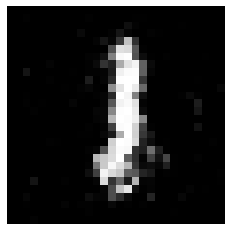

In [22]:
plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

In [6]:
generate_images(1000) #Change the +1000 to +2000 after you generate it the first time! And so on.
#and also change the gen_imgs[1, :, :, 0] to gen_imgs[2, :, :, 0] after first time. And so on.
#ALSO change the location of saved images

IndexError: index 1 is out of bounds for axis 0 with size 1

In [1]:
from keras.models import model_from_json
json_file = open(r"C:\Users\rishi\Documents\DCGAN Images\dcgan.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(r"C:\Users\rishi\Documents\DCGAN Images\dcgan.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [4]:
def generate_images(cnt):
    c=1
    while(c <= cnt):
        noise = np.random.normal(0, 1, (1, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)
        gen_imgs = loaded_model.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :,:,0], cmap='gray')
        plt.axis('off')
        plt.savefig(r"C:\Users\rishi\Documents\CGAN Images\generated_cgan\cgan_{}.jpg".format(c), bbox_inches='tight', pad_inches=-0.0005)
        print("Image {} saved.".format(c))
        c+=1
        plt.close()
generate_images(10000-1246)

AttributeError: 'Model' object has no attribute 'generator'